# Autoregressive simulations

### 2 Stock's returns as AR processes

We use AR processes to simulate log-returns:

\begin{equation*}
    \begin{split}
        \log( r_{1,t})&= \mu_1 + \sum_{k=1}^n \ \theta_{1,k} \cdot \log(r_{1,t-k}) + \theta_{1,0} \cdot \epsilon_{1,t}\\
        \log( r_{2,t}) &= \mu_2 + \sum_{k=1}^n \ \theta_{2,k} \cdot \log(r_{2,t-k}) + \theta_{2,0} \cdot \epsilon_{2,t}
    \end{split}
\end{equation*}



We still use same QLearning algorithm for tabular case, thus we also need to implement a discretizing routine. We bound return at the second decimal, i.e. at $0.01$ with minimum and maximum: $0.96$ and $1.04$.
Hence, this derives $9$ possible values for the discretized data.

We can also compute a discretized optimal policy for the discretized AR process. Hence, it will be used as benchmark similarly to the discrete case. It will contain $9^{2w}$ states.

However, discretizing data makes possible to get same discrete value for both returns which cannot happen for continuous data. Hence, the actions suggested by the discretized optimal policy won't be optimal in the continuous context. Thus, in the case $w=1$, there will be $9$ values of the discrete optimal policy being wrong in the continuous context. This number goes to $81\cdot 9 = 729$ if the window size is equal to $2$. Hence, even if a policy derived by DQN leads to $9$ wrong actions, it has found the true optimal policy as those actions comes from the ill-defined discretized optimal policy. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy.stats
from discrete_methods import *
from continuous_methods import *
import multiprocessing

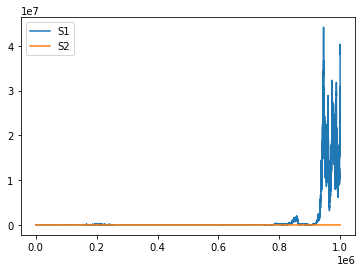

In [75]:
np.random.seed(8472143)
ar=ARProcess2d([0.01, 0.01])
ar_data=np.exp(ar.simulate(1000000))
plt.plot(np.cumprod(ar_data.iloc[0,:]))
plt.plot(np.cumprod(ar_data.iloc[1,:]))
plt.legend(['S1','S2'])
plt.show()

In [76]:
ar_data

0         1         2         3         4         5         6       \
S1  0.990676  0.992060  1.020914  0.996775  0.971142  0.992672  1.003564   
S2  1.002267  1.012079  1.005913  1.020570  1.006140  1.011857  0.993066   

      7         8         9       ...    999990    999991    999992    999993  \
S1  1.005117  1.008287  0.994109  ...  1.017278  1.001546  1.010568  0.990268   
S2  1.008674  0.999833  1.011742  ...  1.007120  0.990115  0.985457  1.021732   

      999994    999995    999996    999997    999998    999999  
S1  0.988226  1.002571  0.998349  1.005654  1.001581  1.003559  
S2  0.995486  1.001865  0.997014  1.016606  0.997057  0.988554  

[2 rows x 1000000 columns]

In [77]:
Ntest=10000
ar_test_first=np.exp(ar.simulate(Ntest))


#### We can compute the discrete version of the optimal policy, by discretizing the AR process and consider it as a Markov process

The transition matrix of its discrete version is given below, we saw that probabilities don't sum exactly to one due to machine precision error, but it shouldn't really matter since the errors are of the order $1e-5$.

In [6]:
trans=ar.transition_matrix()
prob=dict()
for k in trans.keys():
    prob[k[:11]]=0
for k in trans.keys():
    if prob[k[:11]]==0:
        for l in trans.keys():
            if l.startswith(k[:11]):
                prob[k[:11]] += trans[l]


In [7]:
prob

{'[0.96, 0.96': 0.9999860794619992,
 '[0.96, 0.97': 0.9999859815575094,
 '[0.96, 0.98': 0.9999858689856315,
 '[0.96, 0.99': 0.9999857420019364,
 '[0.96, 1.0]': 0.9999856008302194,
 '[0.96, 1.01': 0.9999854456649462,
 '[0.96, 1.02': 0.9999852766734983,
 '[0.96, 1.03': 0.9999850939982224,
 '[0.96, 1.04': 0.999984897758307,
 '[0.97, 0.96': 0.9999859815575094,
 '[0.97, 0.97': 0.9999858836530292,
 '[0.97, 0.98': 0.9999857710811615,
 '[0.97, 0.99': 0.9999856440974794,
 '[0.97, 1.0]': 0.999985502925776,
 '[0.97, 1.01': 0.9999853477605178,
 '[0.97, 1.02': 0.9999851787690864,
 '[0.97, 1.03': 0.9999849960938278,
 '[0.97, 1.04': 0.9999847998539323,
 '[0.98, 0.96': 0.9999858689856318,
 '[0.98, 0.97': 0.9999857710811616,
 '[0.98, 0.98': 0.9999856585093065,
 '[0.98, 0.99': 0.9999855315256382,
 '[0.98, 1.0]': 0.9999853903539513,
 '[0.98, 1.01': 0.999985235188711,
 '[0.98, 1.02': 0.9999850661972985,
 '[0.98, 1.03': 0.9999848835220605,
 '[0.98, 1.04': 0.9999846872821869,
 '[0.99, 0.96': 0.9999857420019

In [32]:
true_qval=ar.discrete_true_qval(1e-5)

Time needed to converge with delta =  1e-05  :  91


In [34]:
for k in true_qval.keys():
    print(k, ' Optimal : ', np.argmax(true_qval[k]))

[0.96, 0.96]  Optimal :  5
[0.96, 0.97]  Optimal :  0
[0.96, 0.98]  Optimal :  0
[0.96, 0.99]  Optimal :  0
[0.96, 1.0]  Optimal :  0
[0.96, 1.01]  Optimal :  0
[0.96, 1.02]  Optimal :  0
[0.96, 1.03]  Optimal :  0
[0.96, 1.04]  Optimal :  0
[0.97, 0.96]  Optimal :  10
[0.97, 0.97]  Optimal :  5
[0.97, 0.98]  Optimal :  0
[0.97, 0.99]  Optimal :  0
[0.97, 1.0]  Optimal :  0
[0.97, 1.01]  Optimal :  0
[0.97, 1.02]  Optimal :  0
[0.97, 1.03]  Optimal :  0
[0.97, 1.04]  Optimal :  0
[0.98, 0.96]  Optimal :  10
[0.98, 0.97]  Optimal :  10
[0.98, 0.98]  Optimal :  5
[0.98, 0.99]  Optimal :  0
[0.98, 1.0]  Optimal :  0
[0.98, 1.01]  Optimal :  0
[0.98, 1.02]  Optimal :  0
[0.98, 1.03]  Optimal :  0
[0.98, 1.04]  Optimal :  0
[0.99, 0.96]  Optimal :  10
[0.99, 0.97]  Optimal :  10
[0.99, 0.98]  Optimal :  10
[0.99, 0.99]  Optimal :  5
[0.99, 1.0]  Optimal :  0
[0.99, 1.01]  Optimal :  0
[0.99, 1.02]  Optimal :  0
[0.99, 1.03]  Optimal :  0
[0.99, 1.04]  Optimal :  0
[1.0, 0.96]  Optimal :  10

#### We remark that for $[1.04, 1.03]$, the discretized optimal policy chose optimal action as $a=0.9$ instead of $a=1.0$.

This is due to the precision error when computing the transition probabilities at the edge of the discretization routine.

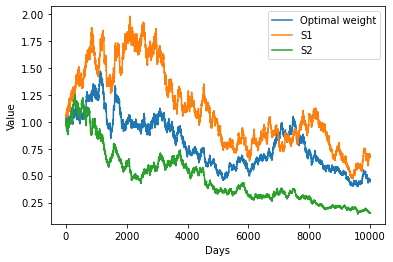

In [78]:
w_opt=exploit_optimal(true_qval, discretize(ar_test_first),window=1)
ret_opt = np.sum(w_opt * ar_test_first.iloc[:, 1:], axis=0)
plt.plot(np.cumprod(ret_opt))
plt.plot(np.cumprod(ar_test_first.iloc[0,1:]))
plt.plot(np.cumprod(ar_test_first.iloc[1,:]))
plt.legend(['Optimal weight', 'S1','S2'])
plt.xlabel('Days')
plt.ylabel('Value')
plt.show()

In [91]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for decay_rate in [100,10,1]:
        for tau in [1,0.8]:
            params.extend([create_param_QLearning(pd.DataFrame(discretize(ar_data),index=['S1','S2']) ,np.array(discretize(ar_test_first)),  window=1, decay_rate=decay_rate,tau=tau,true_qval = true_qval,adaptive_lr=True)])
            
    res_QLearning_ar = pool.map(multi_train_QLearning, params)



 

Learning rate dependent on states: Decay rate : 100, Beta : 0, Tau : 1


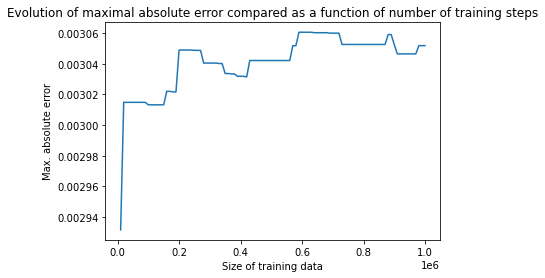

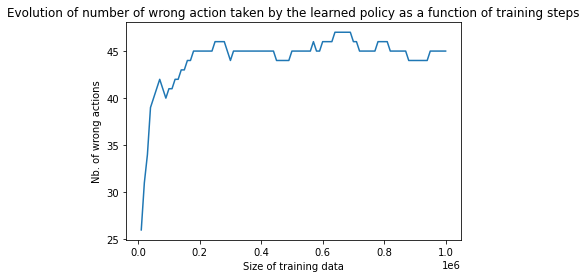


 Wrong actions : 
There are a lot of wrong actions :  45


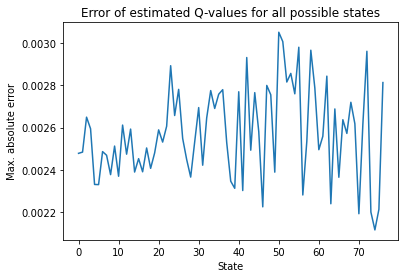


 

Learning rate dependent on states: Decay rate : 100, Beta : 0, Tau : 0.8


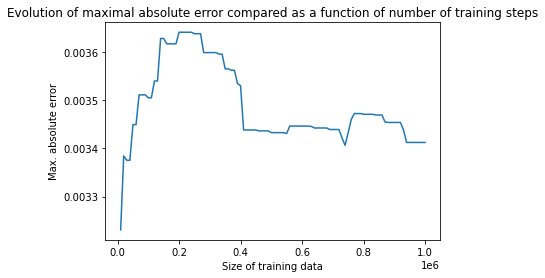

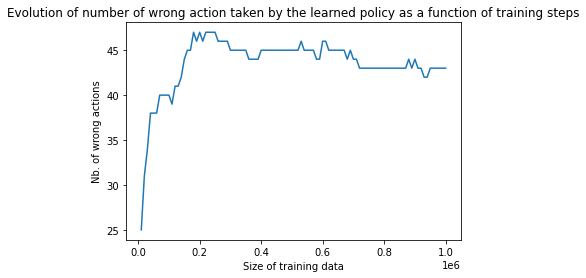


 Wrong actions : 
There are a lot of wrong actions :  43


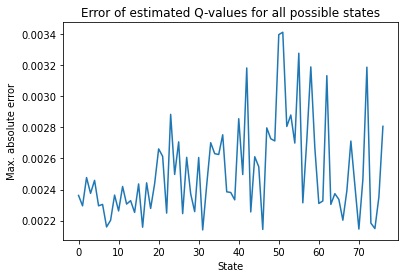


 

Learning rate dependent on states: Decay rate : 10, Beta : 0, Tau : 1


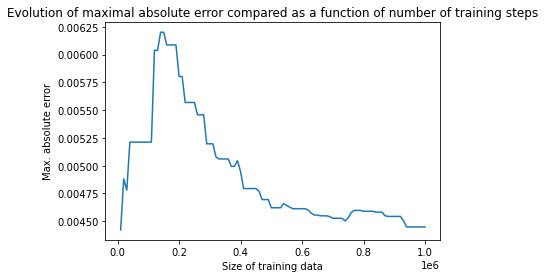

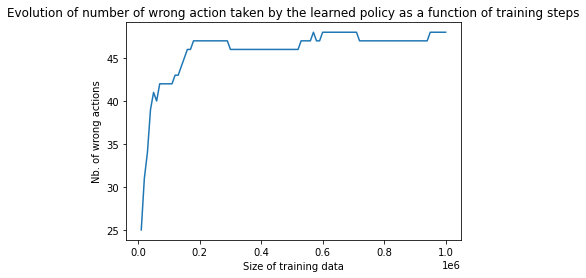


 Wrong actions : 
There are a lot of wrong actions :  48


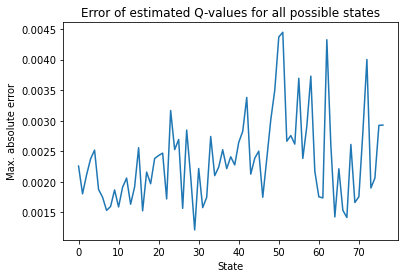


 

Learning rate dependent on states: Decay rate : 10, Beta : 0, Tau : 0.8


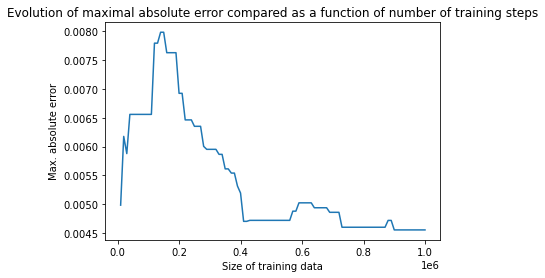

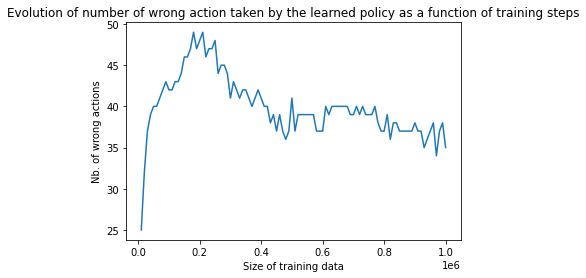


 Wrong actions : 
There are a lot of wrong actions :  35


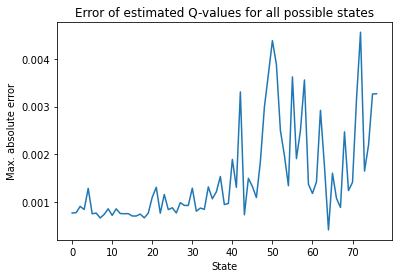


 

Learning rate dependent on states: Decay rate : 1, Beta : 0, Tau : 1


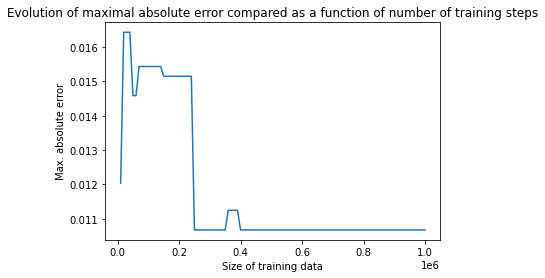

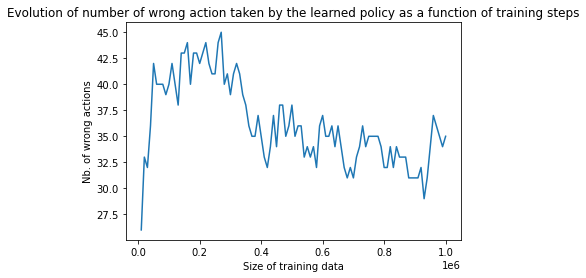


 Wrong actions : 
There are a lot of wrong actions :  35


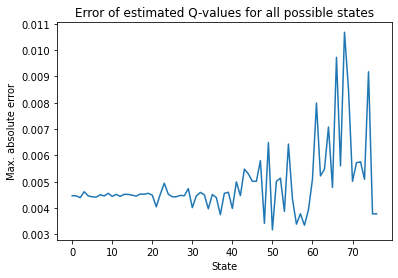


 

Learning rate dependent on states: Decay rate : 1, Beta : 0, Tau : 0.8


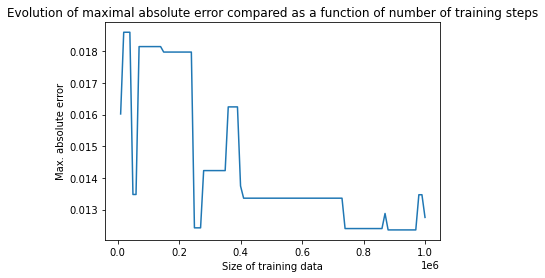

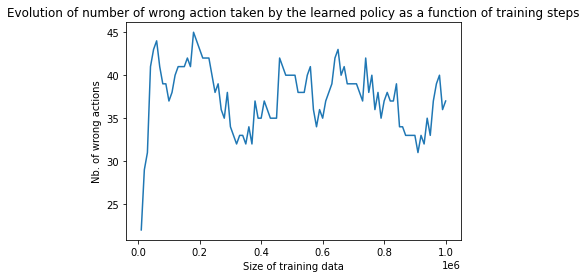


 Wrong actions : 
There are a lot of wrong actions :  37


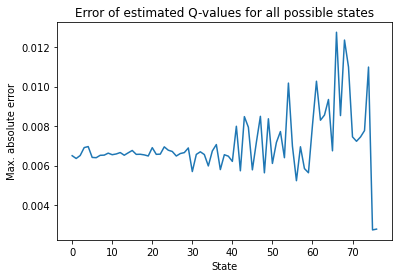

In [92]:
for x in res_QLearning_ar:
    plot_res_multi_QLearning(x,true_qval)

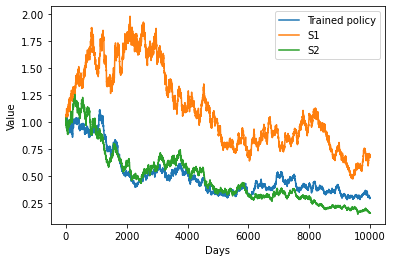

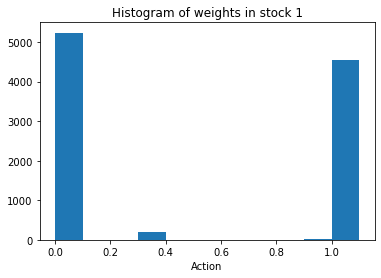

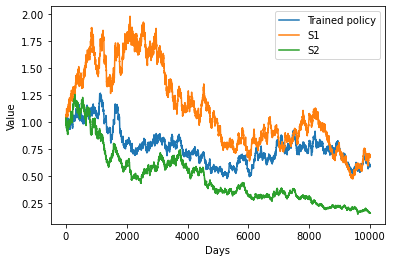

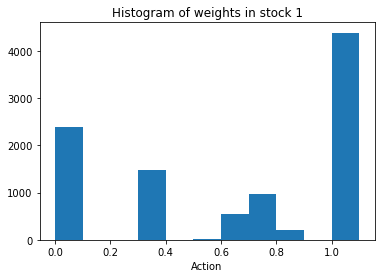

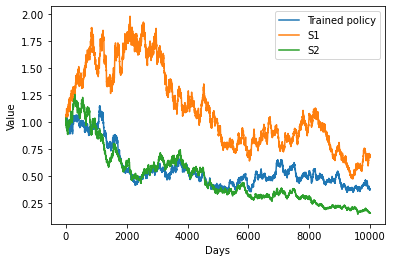

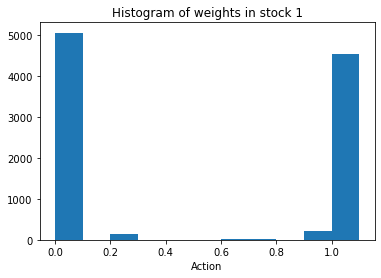

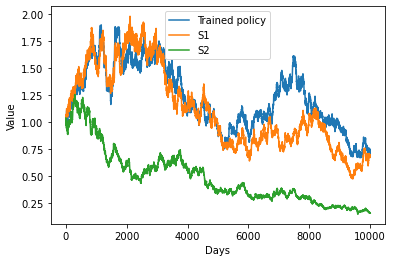

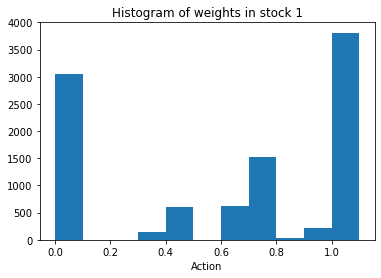

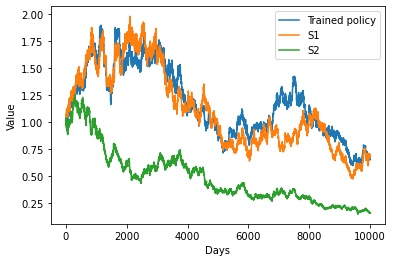

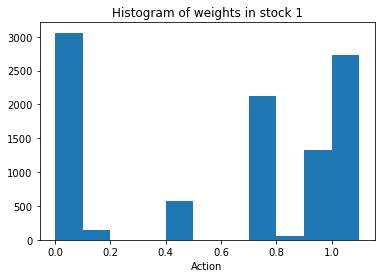

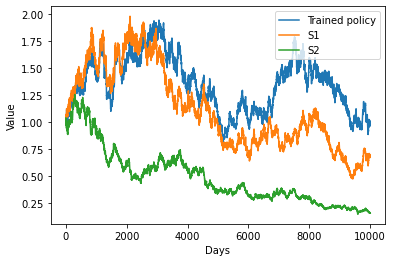

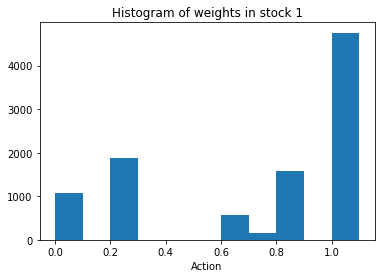

In [96]:
for x in res_QLearning_ar:
    
    plt.plot(np.cumprod(np.sum(x['exploit_test']['w'] * ar_test_first.iloc[:, 1:], axis=0)))
    plt.plot(np.cumprod(ar_test_first.iloc[0,1:]))
    plt.plot(np.cumprod(ar_test_first.iloc[1,1:]))
    plt.legend(['Trained policy', 'S1','S2'])
    plt.xlabel('Days')
    plt.ylabel('Value')
    plt.show()
    
    plt.hist(x['exploit_test']['w'][0, :], bins=np.arange(0, 12) / 10)
    plt.title('Histogram of weights in stock 1')
    plt.xlabel('Action')
    plt.show()
    

## DQN

In [46]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.001,0.0001,0.00001]:
        for batch_size in [32,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_data.iloc[:,:100000]),np.array(ar_test_first), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval)])
    
    jobs_basic = pool.map(multi_train, params)



 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  46


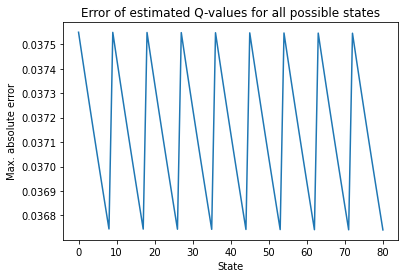


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  46


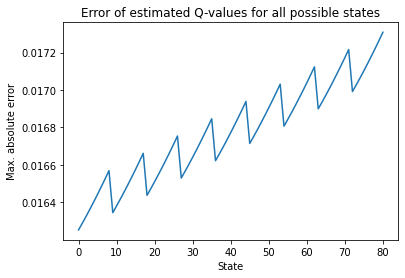


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  46


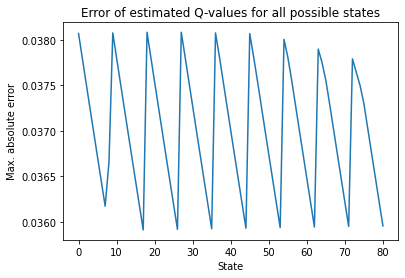


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  46


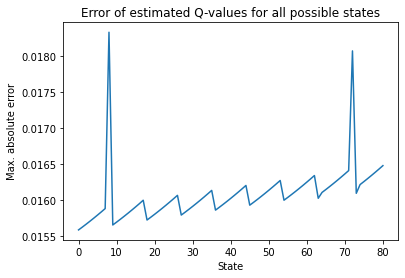


 

 Parameters are : lr = 1e-05, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  46


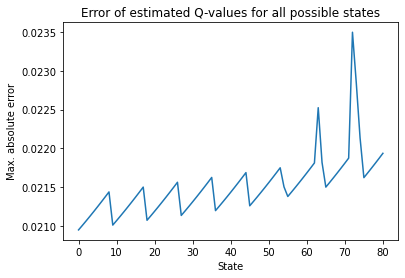


 

 Parameters are : lr = 1e-05, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  46


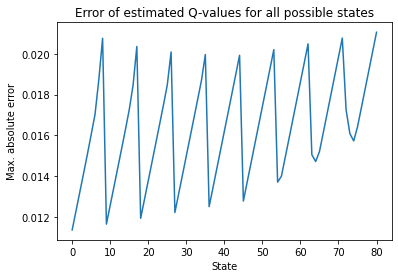

In [47]:
for j in jobs_basic:
    plot_res_from_multi(j,true_qval)

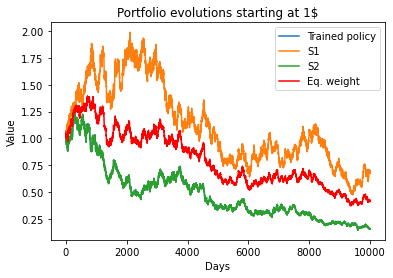

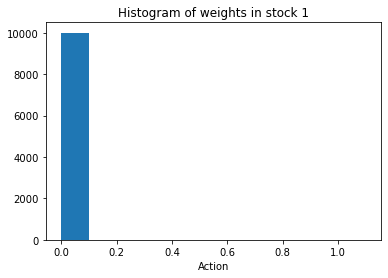

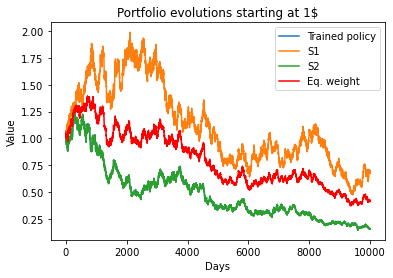

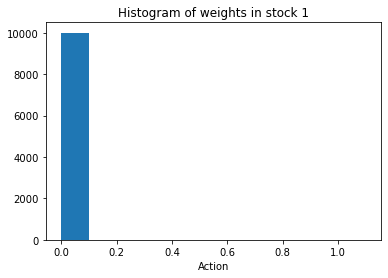

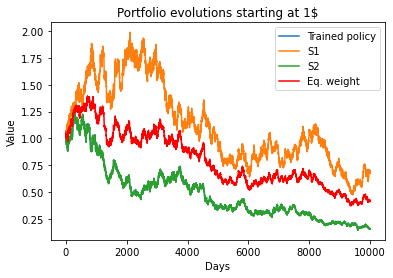

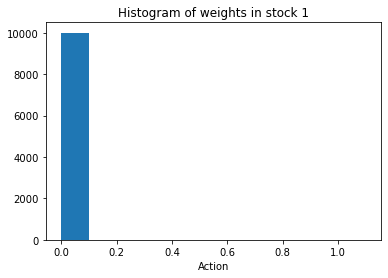

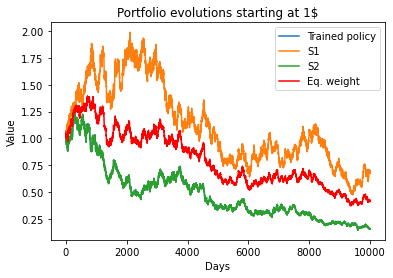

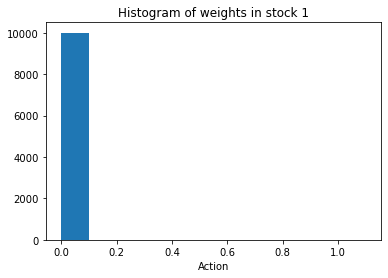

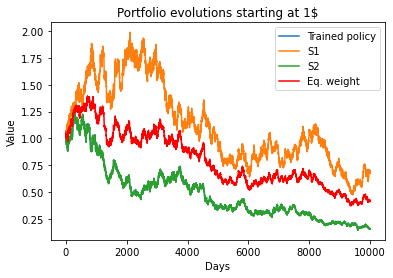

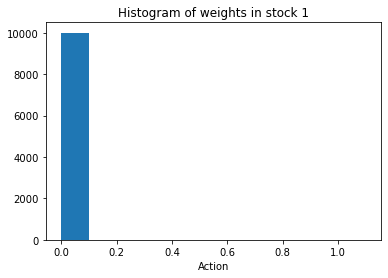

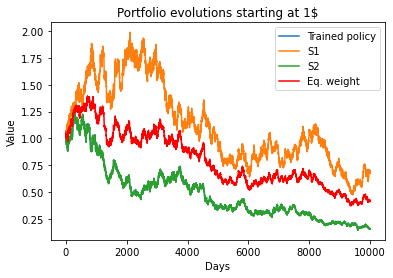

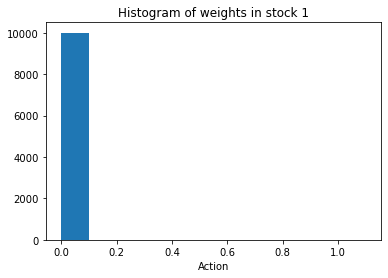

In [48]:
for j in jobs_basic:
    plot_result(j['exploit_test'])

In [43]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.001,0.0001]:
        for batch_size in [32,64,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_data.iloc[:,:100000]),np.array(ar_test_first), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval,adaptive_lr=True)])
    
    jobs_basic_adaptlr = pool.map(multi_train, params)



 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  53


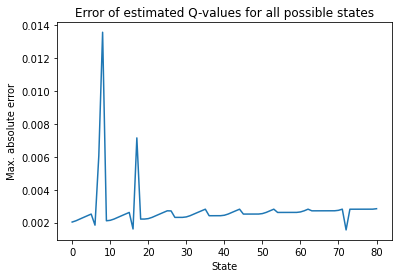


 

 Parameters are : lr = 0.001, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  46


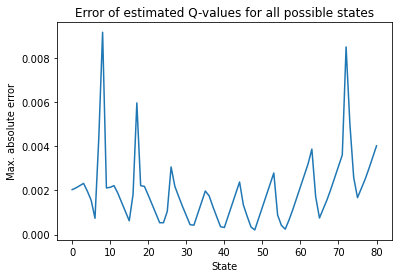


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  81


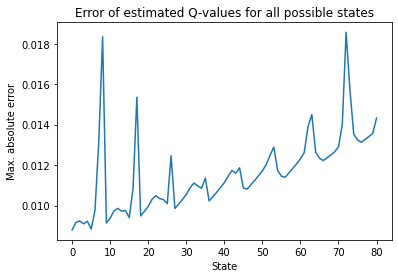


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  42


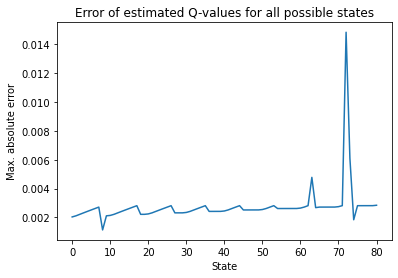


 

 Parameters are : lr = 0.0001, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  44


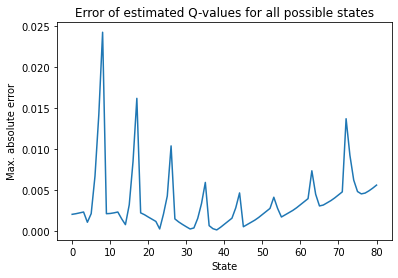


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  46


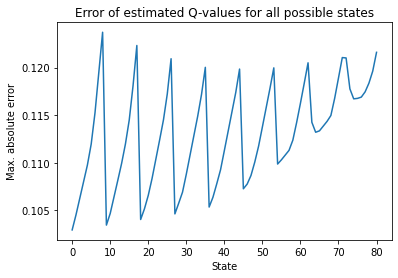

In [44]:
for j in jobs_basic_adaptlr:
    plot_res_from_multi(j,true_qval)

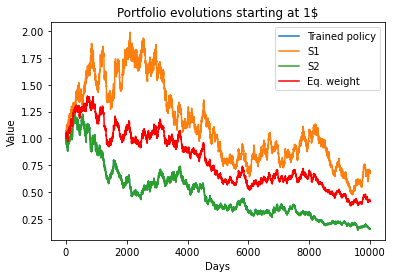

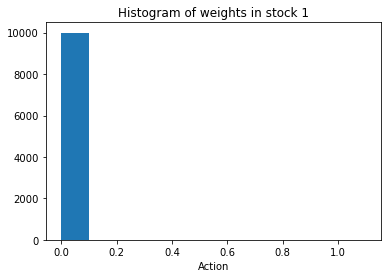

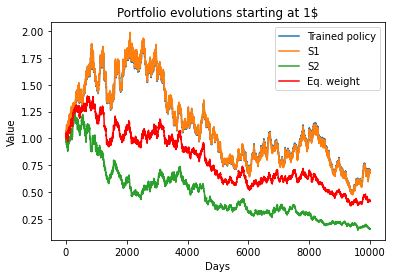

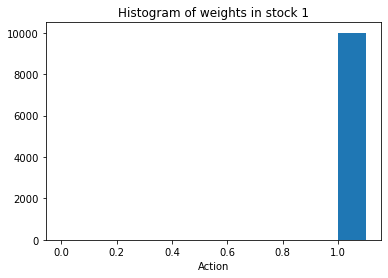

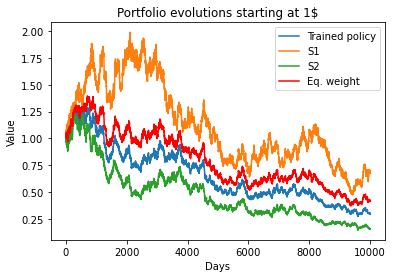

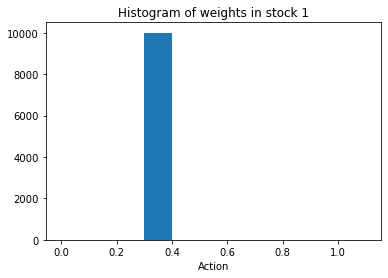

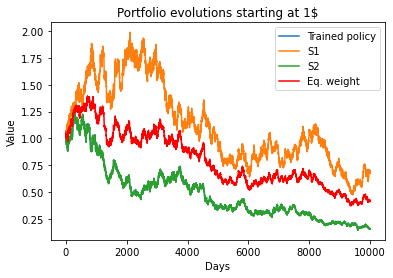

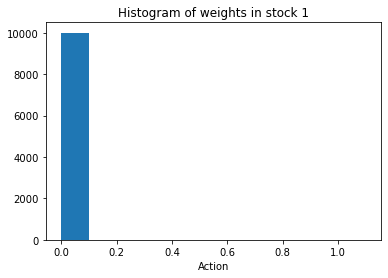

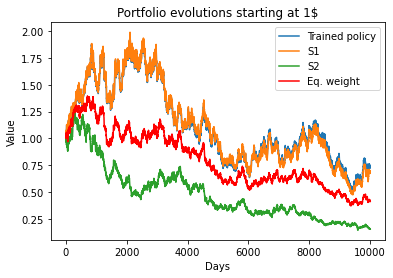

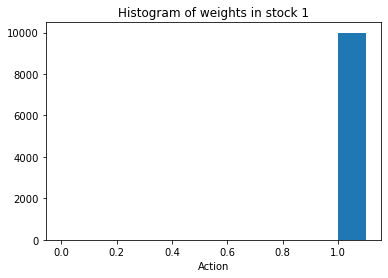

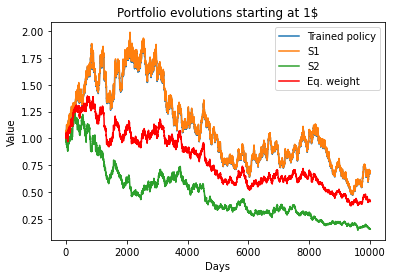

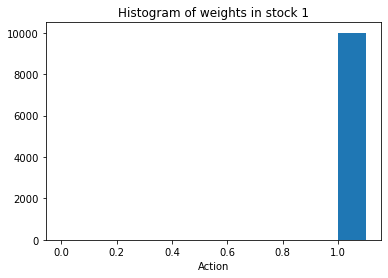

In [45]:
for j in jobs_basic_adaptlr:
    plot_result(j['exploit_test'])

Finally, we conclude that discretizing lets us derive a policy closer to the discretized optimal one. Nevertheless, the discretized optimal policy doesn't even beat the first stock which was chosen most of the time by DQN learning. In addition, since log-returns are simulated by:

\begin{equation*}
    \log(r_{i,t}) = 0.01 \cdot \epsilon_{i,t} + 0.01 \cdot \log(r_{i,t-1}), \quad \forall i \in \{1,2\}
\end{equation*}

it implies that the leading elements of this simulation corresponds to the white noise as $\epsilon_{i,t}$ will take higher values than $\log(r_{i,t-1})$ lying between $[-0.02, 0.02]$. Hence, this makes sense that DQN wasn't able to learn a better policy leading to no assured good performance.


# Return for stock 1 has small positive mean

In [18]:
ar2dm=ARProcess2d([0.01,0.01],np.array([[0.01],[0.]]))
Nsim=100000
window=1
gamma=0.98
ar2dm_data=np.exp(ar2dm.simulate(Nsim))

Ntest=10000
ar2dm_test=np.exp(ar2dm.simulate(Ntest))

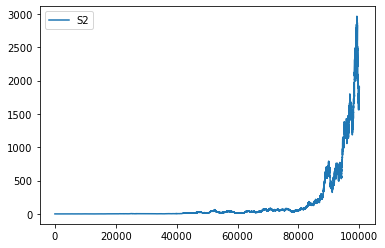

In [19]:
plt.plot(np.cumprod(np.array(ar2dm_data.iloc[1,:])))
plt.legend(['S2'])
plt.show()

#### Stock 1 cannot be plotted as it goes quickly to infinity

In [20]:
true_qvalm=ar2dm.discrete_true_qval(1e-3)

Time needed to converge with delta =  0.001  :  115


### Discretized optimal policy corresponds to the true optimal policy in the continuous context: invest always in first stock.

In [21]:
ar2dm_data_discr = discretize(ar2dm_data)

## Q-Learning

In [24]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for decay_rate in [1,0.1,0.01]:
        for tau in [1,0.8]:
            for w in [1,2]:
                if w==1:
                    params.extend([create_param_QLearning(discretize(ar2dm_data), np.array(discretize(ar2dm_test)),  window=w, decay_rate=decay_rate,tau=tau,true_qval = true_qvalm,adaptive_lr=True)])
                else:
                    params.extend([create_param_QLearning(discretize(ar2dm_data), np.array(discretize(ar2dm_test)),  window=w, decay_rate=decay_rate,tau=tau,true_qval = extend_qtable_discrete(true_qvalm),adaptive_lr=True)])

    jobs_QL_mu = pool.map(multi_train_QLearning, params)
    


 

Learning rate dependent on states: Decay rate : 1, Beta : 0, Tau : 1


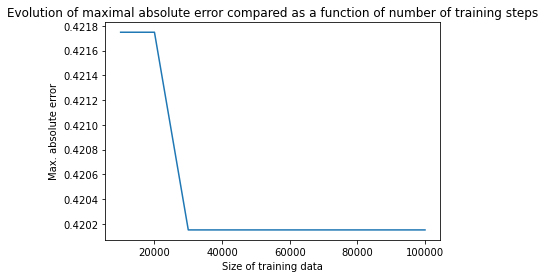

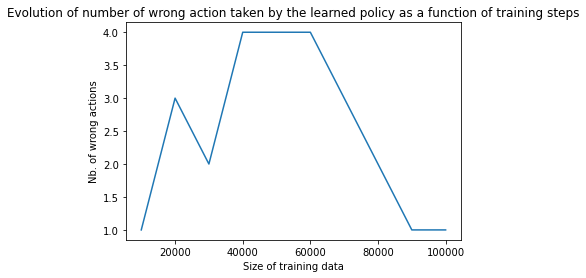


 Wrong actions : 
[0.99, 0.96] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0


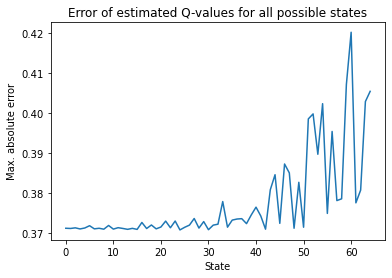


 

Learning rate dependent on states: Decay rate : 1, Beta : 0, Tau : 1


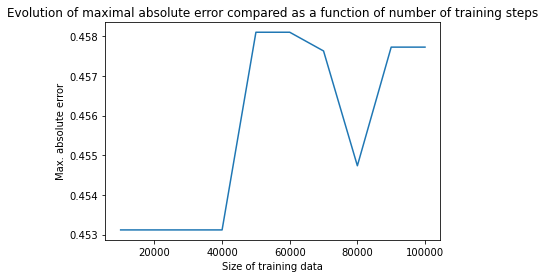

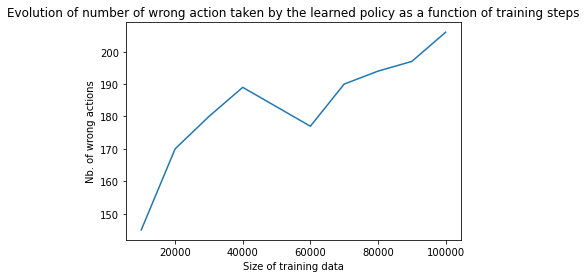


 Wrong actions : 
There are a lot of wrong actions :  206


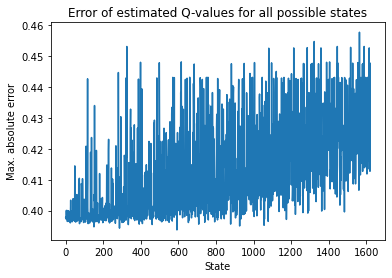


 

Learning rate dependent on states: Decay rate : 1, Beta : 0, Tau : 0.8


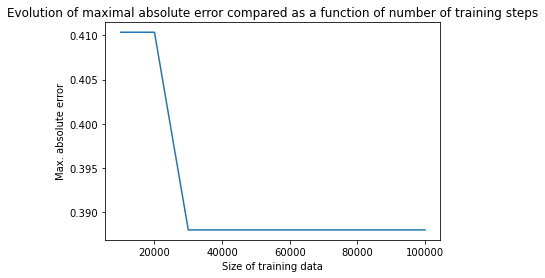

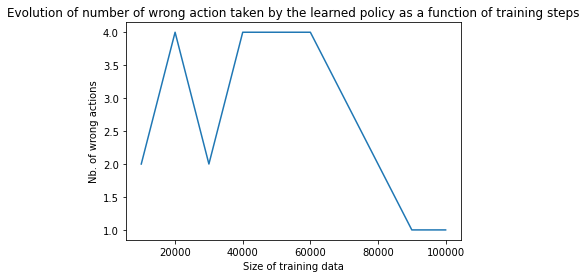


 Wrong actions : 
[0.99, 0.96] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0


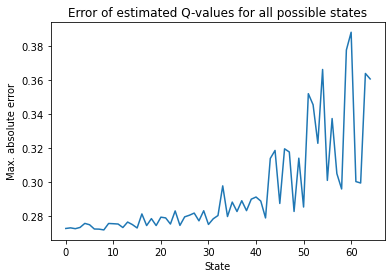


 

Learning rate dependent on states: Decay rate : 1, Beta : 0, Tau : 0.8


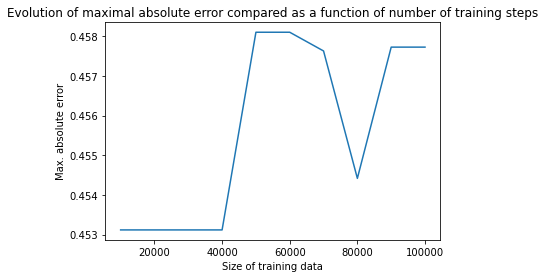

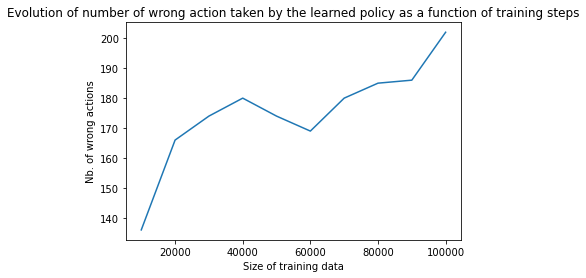


 Wrong actions : 
There are a lot of wrong actions :  202


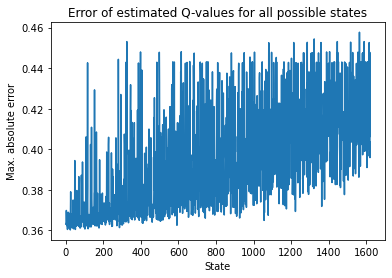


 

Learning rate dependent on states: Decay rate : 0.1, Beta : 0, Tau : 1


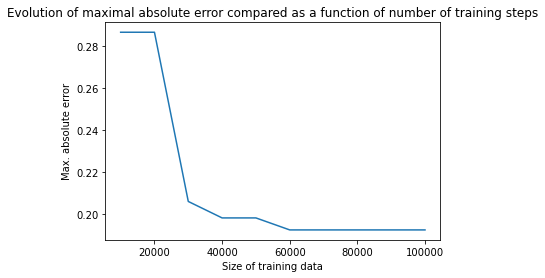

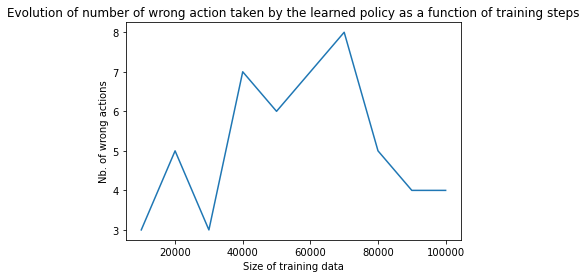


 Wrong actions : 
[0.97, 1.0] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[1.03, 1.04] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[1.02, 1.04] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[0.99, 0.96] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0


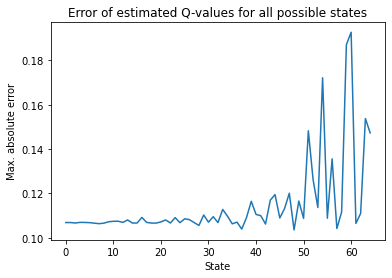


 

Learning rate dependent on states: Decay rate : 0.1, Beta : 0, Tau : 1


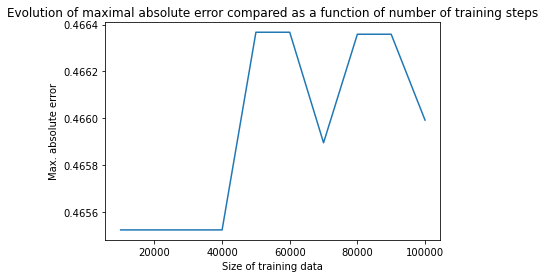

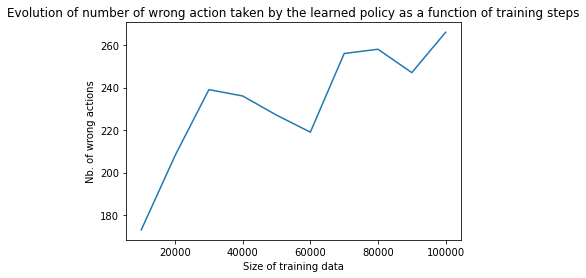


 Wrong actions : 
There are a lot of wrong actions :  266


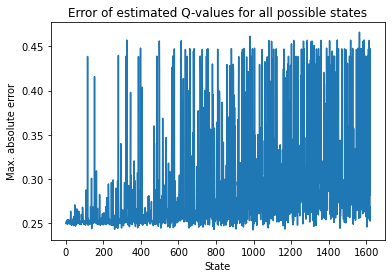


 

Learning rate dependent on states: Decay rate : 0.1, Beta : 0, Tau : 0.8


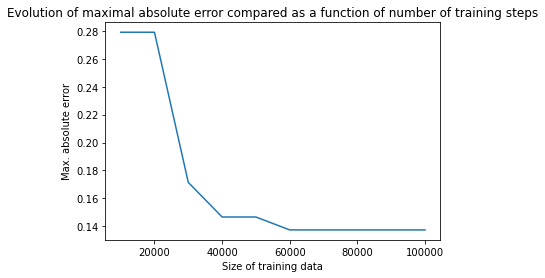

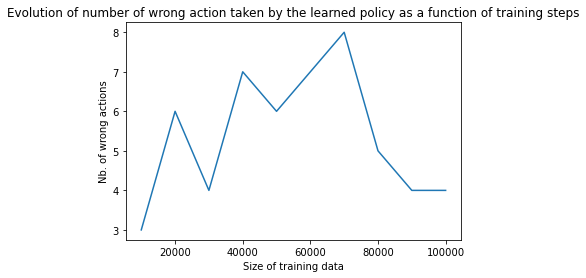


 Wrong actions : 
[0.97, 1.0] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[1.03, 1.04] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[1.02, 1.04] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[0.99, 0.96] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0


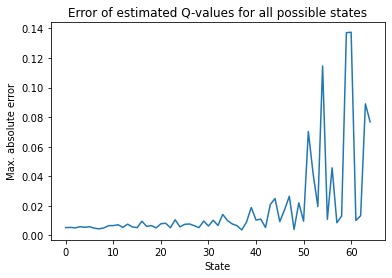


 

Learning rate dependent on states: Decay rate : 0.1, Beta : 0, Tau : 0.8


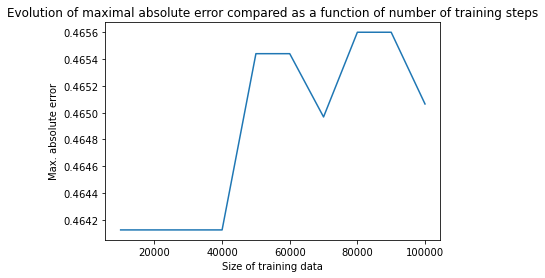

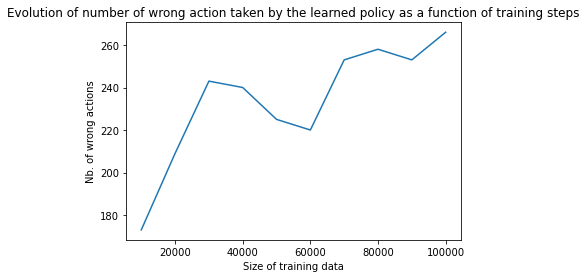


 Wrong actions : 
There are a lot of wrong actions :  266


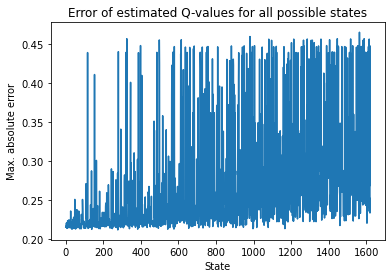


 

Learning rate dependent on states: Decay rate : 0.01, Beta : 0, Tau : 1


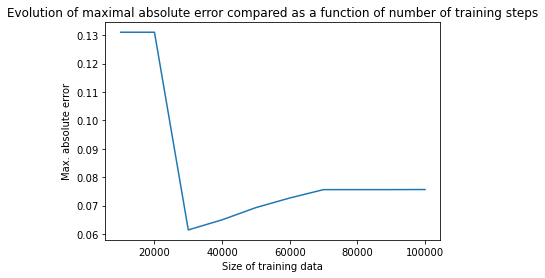

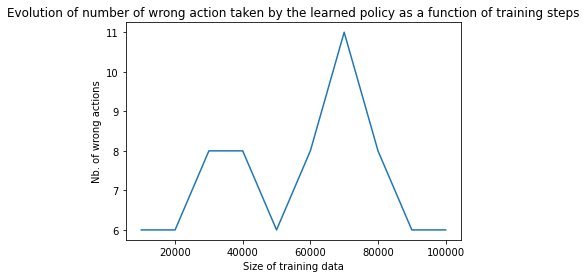


 Wrong actions : 
[1.02, 0.97] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[0.98, 0.99] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[0.97, 1.0] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[1.03, 1.04] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[1.02, 1.04] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[0.99, 0.96] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0


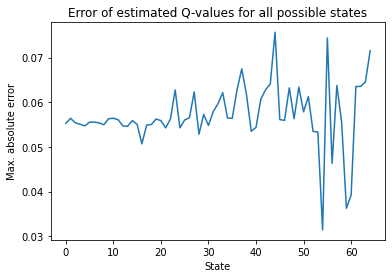


 

Learning rate dependent on states: Decay rate : 0.01, Beta : 0, Tau : 1


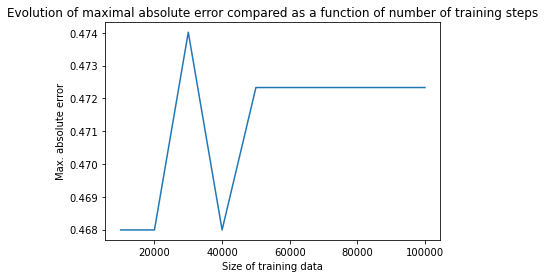

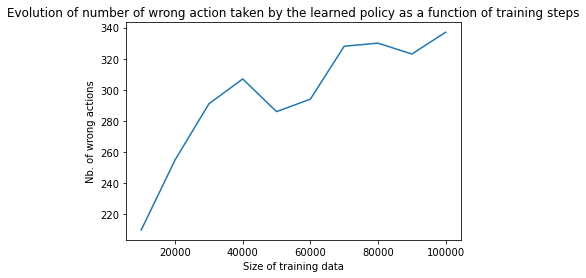


 Wrong actions : 
There are a lot of wrong actions :  337


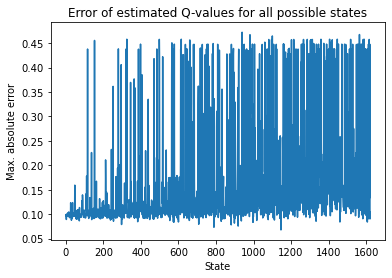


 

Learning rate dependent on states: Decay rate : 0.01, Beta : 0, Tau : 0.8


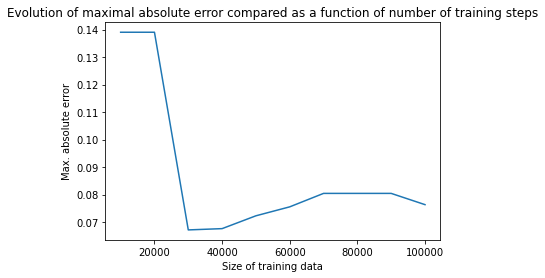

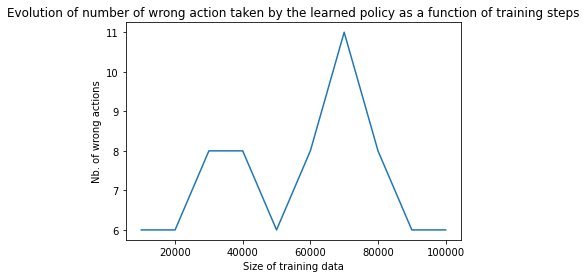


 Wrong actions : 
[1.02, 0.97] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[0.98, 0.99] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[0.97, 1.0] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[1.03, 1.04] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[1.02, 1.04] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0
[0.99, 0.96] ; Action from discrete policy :  10 ; Action from Q-Learning algorithm :  0


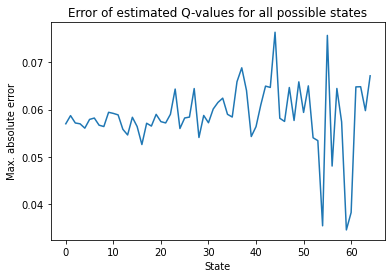


 

Learning rate dependent on states: Decay rate : 0.01, Beta : 0, Tau : 0.8


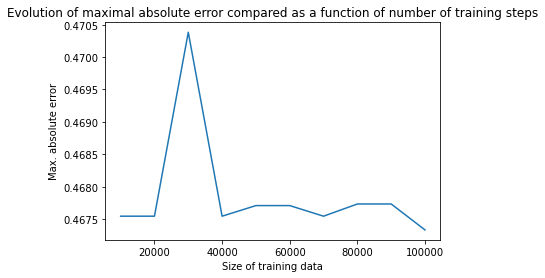

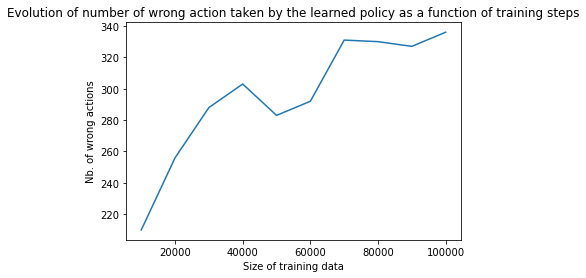


 Wrong actions : 
There are a lot of wrong actions :  336


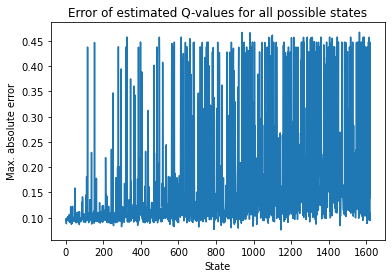

In [25]:
for x in jobs_QL_mu:
    if len(list(x['q_val'].keys())[0]) > 13:
        plot_res_multi_QLearning(x,extend_qtable_discrete(true_qvalm))
    else:
        plot_res_multi_QLearning(x,true_qvalm)

In [26]:
for k in jobs_QL_mu[2]['q_val'].keys():
    if np.argmax(jobs_QL_mu[2]['q_val'][k]) != np.argmax(true_qvalm[k]): 
        print(k, ': Estimated : ', np.argmax(jobs_QL_mu[2]['q_val'][k]), ', Optimal : ', np.argmax(true_qvalm[k]))

[0.99, 0.96] : Estimated :  0 , Optimal :  10


In [27]:
num=0
for i in range(ar2dm_data_discr.shape[1]):
    if list(ar2dm_data_discr.iloc[:,i]) == [0.97,0.98]:
        num+=1
        
print('Number of times [0.97,0.98] appears in training data : ',num)

Number of times [0.97,0.98] appears in training data :  4


In [72]:
num=0
for i in range(ar2dm_data_discr.shape[1]):
    if list(ar2dm_data_discr.iloc[:,i]) == [0.99,0.96]:
        num+=1
        
print('Number of times [0.99,0.96] appears in training data : ',num)

Number of times [0.99,0.96] appears in training data :  1


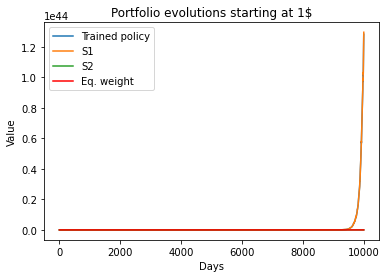

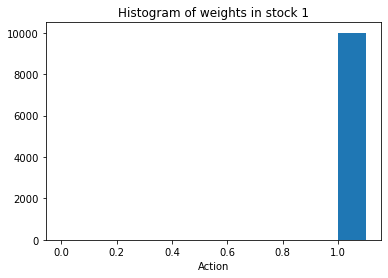

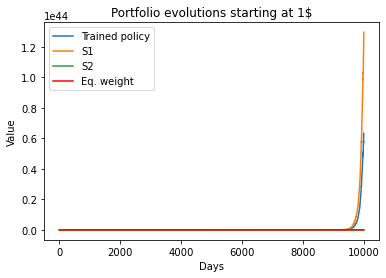

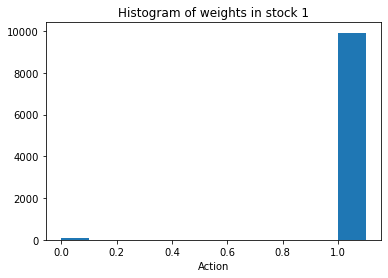

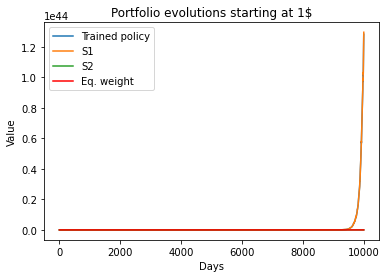

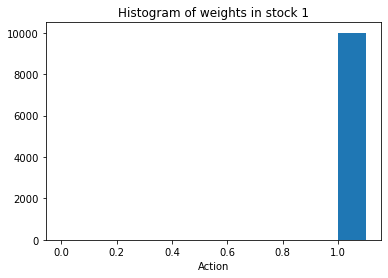

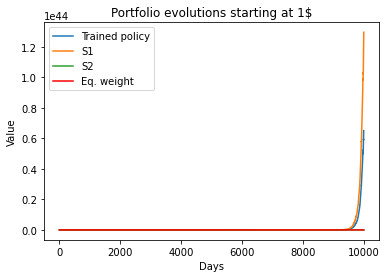

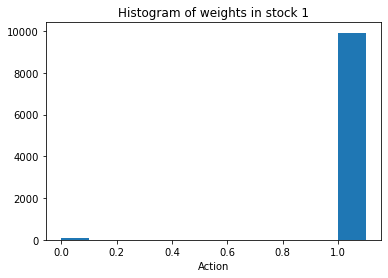

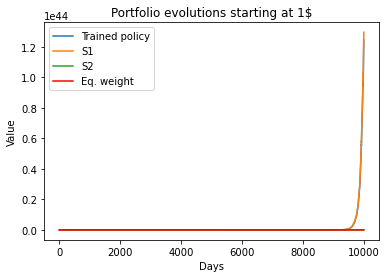

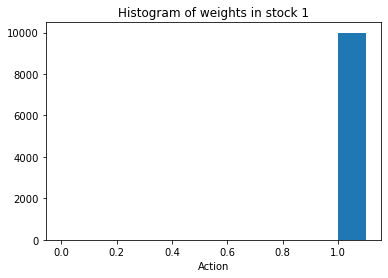

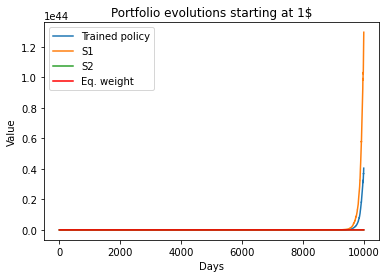

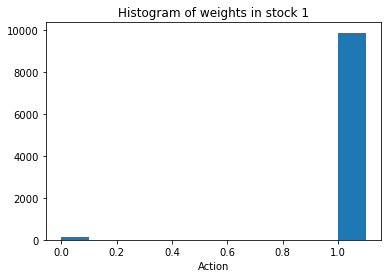

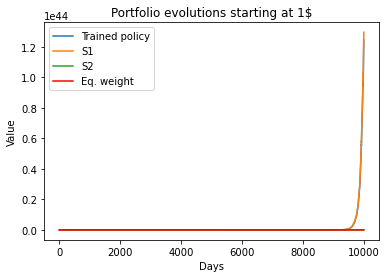

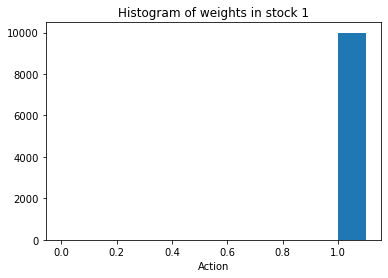

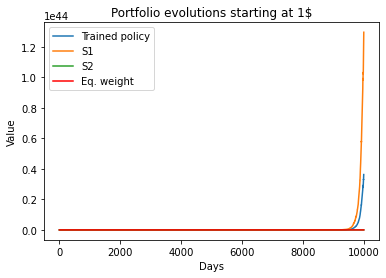

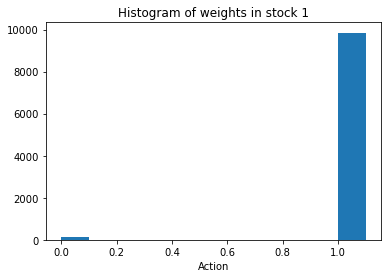

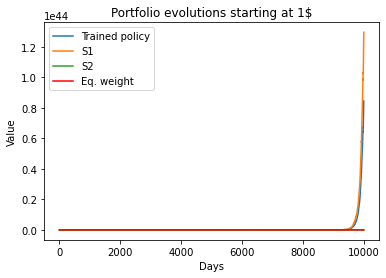

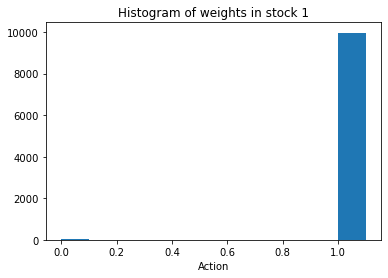

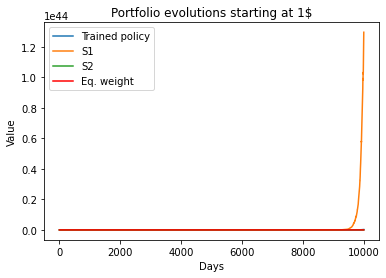

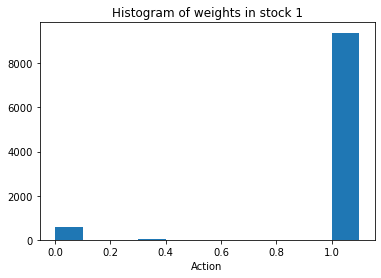

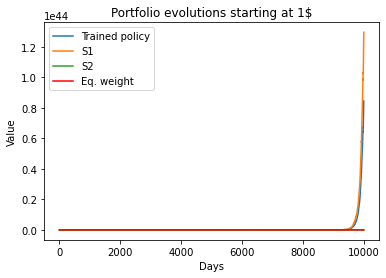

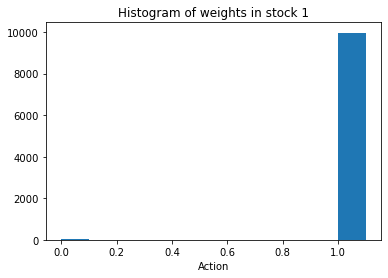

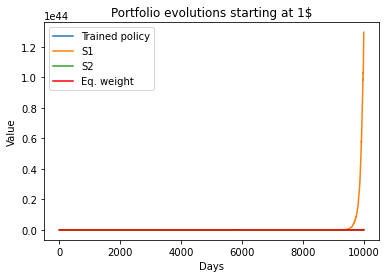

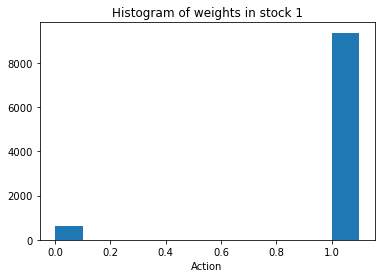

In [73]:
for j in jobs_QL_mu:
    plot_result(j['exploit_test'])

### For window size ($w=1$), the two wrong actions correspond to states appearing only twice or four times. Hence, it doesn't really matter to get them wrong. 

When $w=2$ we get even more wrong actions, nevertheless this comes from the fact that there are even more states which are visited only very few times in the training data.

## Deep Q-Networks

In [74]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,64]:
            params.extend([create_param_DQN(pd.DataFrame(ar2dm_data),np.array(ar2dm_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qvalm)])
    
    jobs_ar = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


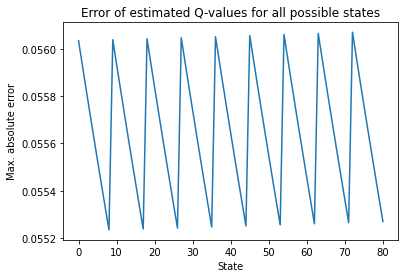


 

 Parameters are : lr = 0.01, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


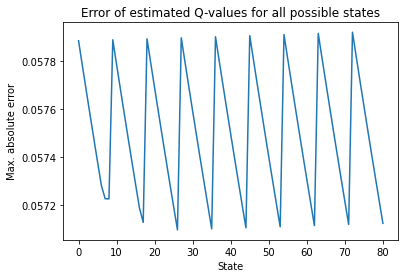


 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


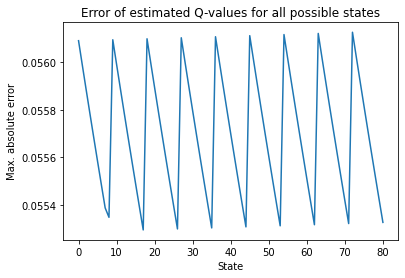


 

 Parameters are : lr = 0.001, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


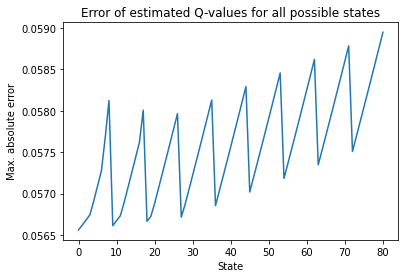


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


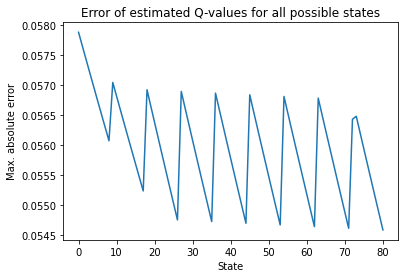


 

 Parameters are : lr = 0.0001, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


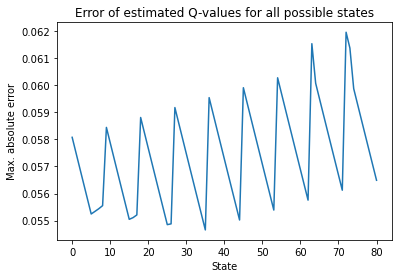

In [75]:
for j in jobs_ar:
    plot_res_from_multi(j,true_qvalm)

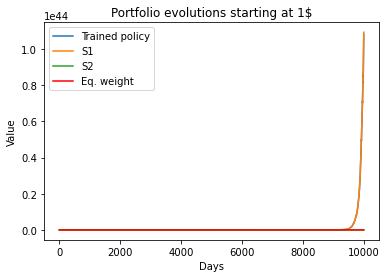

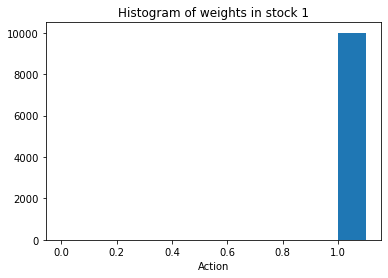

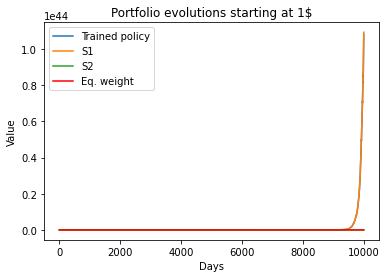

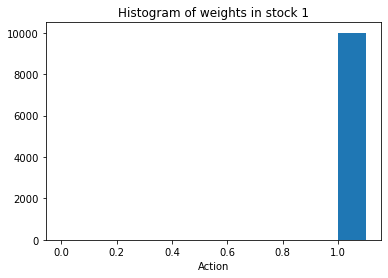

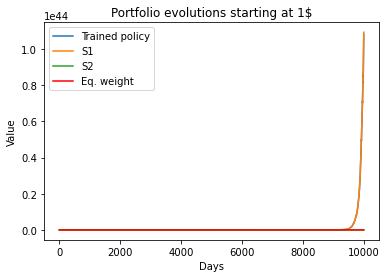

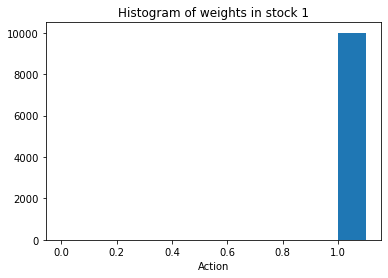

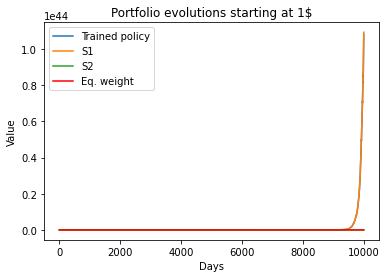

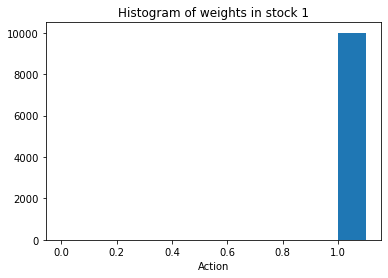

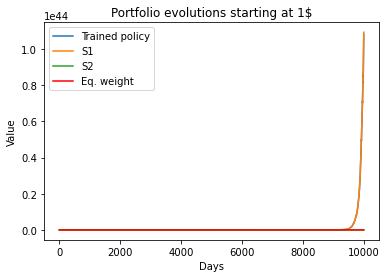

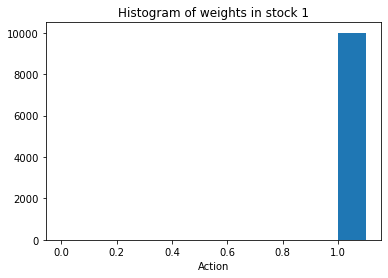

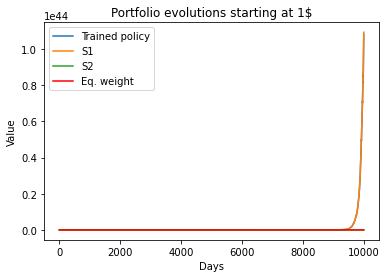

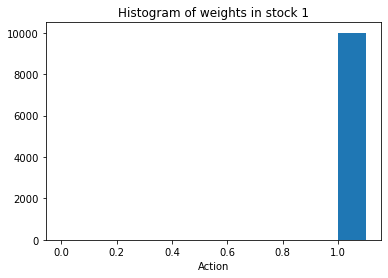

In [78]:
for j in jobs_ar:
    plot_result(j['exploit_test'])

# Window = 2

In [30]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,64]:
            params.extend([create_param_DQN(pd.DataFrame(ar2dm_data),np.array(ar2dm_test), window=2,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=extend_qtable_discrete(true_qvalm))])
    
    jobs_ar_w2 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


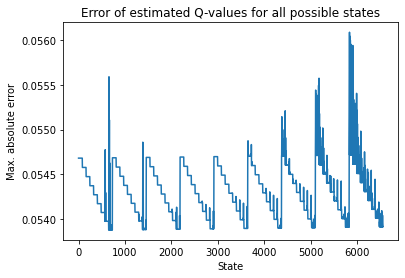


 

 Parameters are : lr = 0.01, window = 2, batch size = 64, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


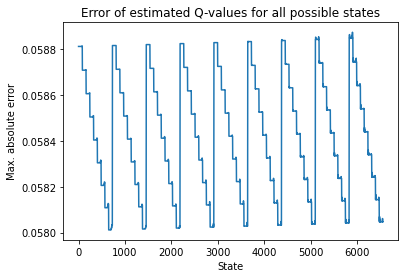


 

 Parameters are : lr = 0.001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


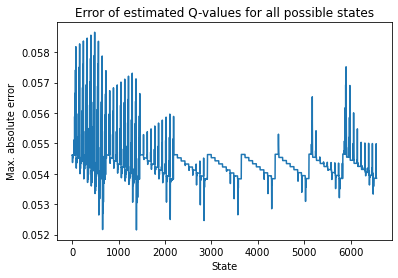


 

 Parameters are : lr = 0.001, window = 2, batch size = 64, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


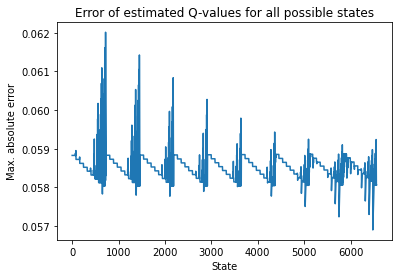


 

 Parameters are : lr = 0.0001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


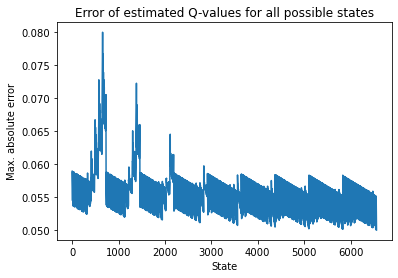


 

 Parameters are : lr = 0.0001, window = 2, batch size = 64, nb. epochs = 100

 Wrong actions : 
Optimal policy derived !!


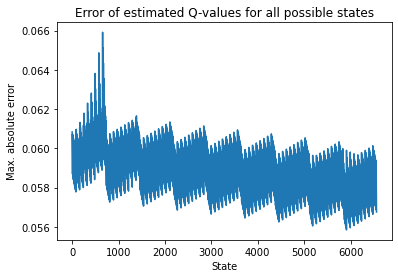

In [31]:
for j in jobs_ar_w2:
    plot_res_from_multi(j, extend_qtable_discrete(true_qvalm))

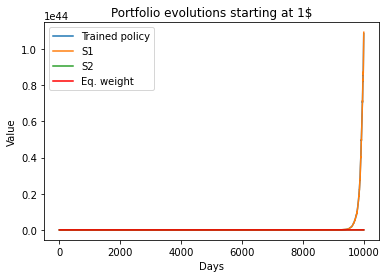

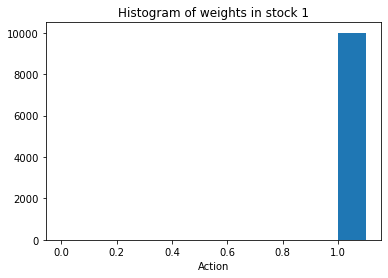

In [32]:
for j in jobs_ar_w2:
    plot_result(j['exploit_test'])

### Optimal policy always derived with no wrong action.

This one advantage of DQN, it doesn't need to see enough time each state to get a good estimation for its q-values as it is built as a deep neural network.

# Correlated ar(1)

In [50]:
np.random.seed(211445739)
corr=0.8
Nsim=100000
ar_corr=ARProcess2d([0.01,.01],corr=corr)
ar_corrtrain=np.exp(ar_corr.simulate(Nsim))

In [51]:
true_qval_corr=ar_corr.discrete_true_qval(1e-8)

Time needed to converge with delta =  1e-08  :  388


In [52]:
for k in true_qval_corr:
    print(k, ' : ', np.argmax(true_qval_corr[k]))

[0.96, 0.96]  :  5
[0.96, 0.97]  :  0
[0.96, 0.98]  :  0
[0.96, 0.99]  :  0
[0.96, 1.0]  :  0
[0.96, 1.01]  :  0
[0.96, 1.02]  :  0
[0.96, 1.03]  :  0
[0.96, 1.04]  :  0
[0.97, 0.96]  :  10
[0.97, 0.97]  :  5
[0.97, 0.98]  :  0
[0.97, 0.99]  :  0
[0.97, 1.0]  :  0
[0.97, 1.01]  :  0
[0.97, 1.02]  :  0
[0.97, 1.03]  :  0
[0.97, 1.04]  :  0
[0.98, 0.96]  :  10
[0.98, 0.97]  :  10
[0.98, 0.98]  :  5
[0.98, 0.99]  :  0
[0.98, 1.0]  :  0
[0.98, 1.01]  :  0
[0.98, 1.02]  :  0
[0.98, 1.03]  :  0
[0.98, 1.04]  :  0
[0.99, 0.96]  :  10
[0.99, 0.97]  :  10
[0.99, 0.98]  :  10
[0.99, 0.99]  :  5
[0.99, 1.0]  :  0
[0.99, 1.01]  :  0
[0.99, 1.02]  :  0
[0.99, 1.03]  :  0
[0.99, 1.04]  :  0
[1.0, 0.96]  :  10
[1.0, 0.97]  :  10
[1.0, 0.98]  :  10
[1.0, 0.99]  :  10
[1.0, 1.0]  :  5
[1.0, 1.01]  :  0
[1.0, 1.02]  :  0
[1.0, 1.03]  :  0
[1.0, 1.04]  :  0
[1.01, 0.96]  :  10
[1.01, 0.97]  :  10
[1.01, 0.98]  :  10
[1.01, 0.99]  :  10
[1.01, 1.0]  :  10
[1.01, 1.01]  :  5
[1.01, 1.02]  :  0
[1.01, 1.03]

### Same discretized optimal policy as when $\rho=0$, we are interested in introducing some delay.

In [53]:
Ntest=10000

ar_corrtest=np.exp(ar_corr.simulate(Ntest))


# Delay second return by one time-step

Since both ar are simulated with correlated gaussian white noise, delaying the second stock's return creates a time dependence.

We use exactly same data as ar_corrtrain and ar_corrtest, only delayed for second stock's return.

\begin{equation*}
    r_{2,t} \leftarrow r_{2,t+1}, \qquad \forall t\geq 0
\end{equation*}

In [35]:
ar_corrtrain_del=np.array(ar_corrtrain.iloc[:,:-1])
ar_corrtrain_del[1,:]= np.array(ar_corrtrain.iloc[1,1:])
ar_corrtest_del=np.array(ar_corrtest.iloc[:,:-1])
ar_corrtest_del[1,:]=np.array(ar_corrtest.iloc[1,1:])

In [36]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for decay_rate in [0.01,0.001,0.0001]:
        for tau in [1,0.8]:
            for w in [1,2]:
                params.extend([create_param_QLearning(pd.DataFrame(discretize(ar_corrtrain_del), index=['S1','S2']), np.array(discretize(ar_corrtest_del)),  window=w, decay_rate=decay_rate,tau = tau)])

    jobs_QL_del = pool.map(multi_train_QLearning, params)
    

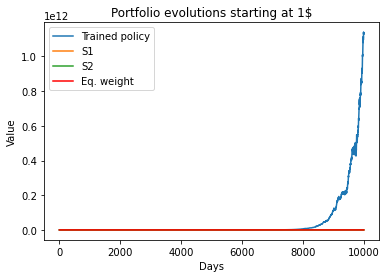

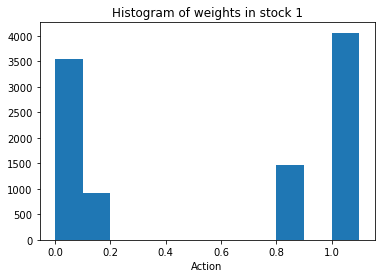

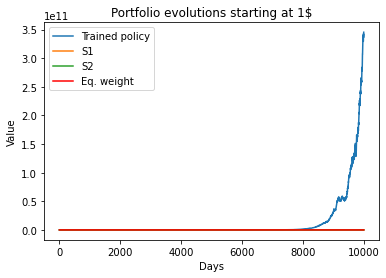

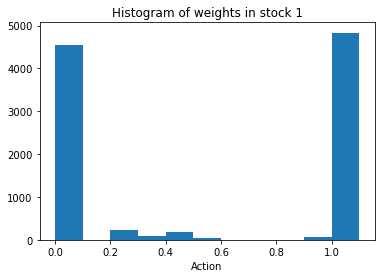

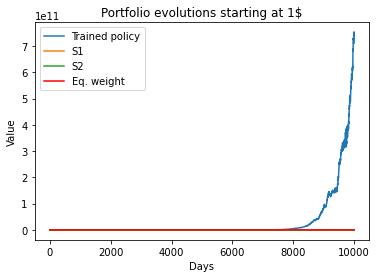

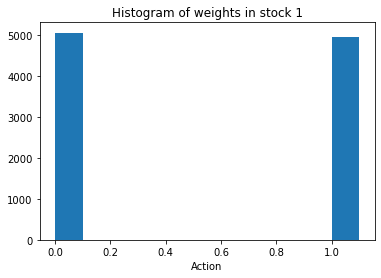

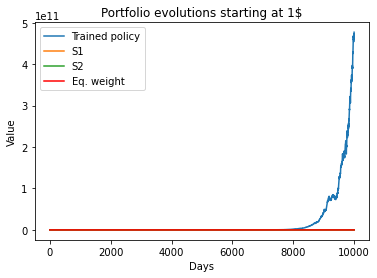

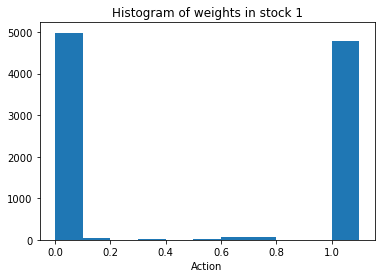

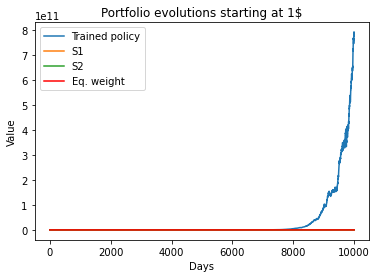

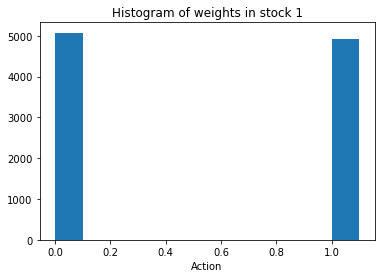

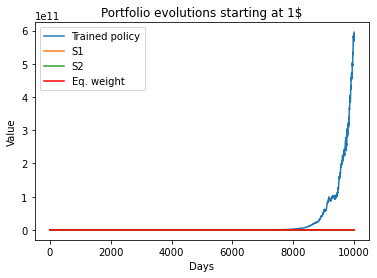

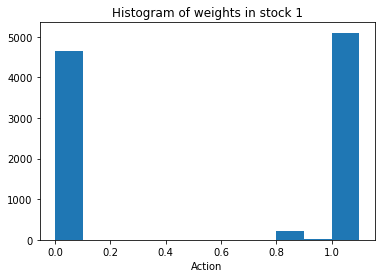

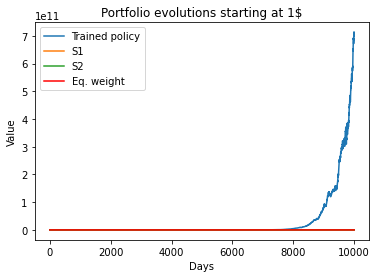

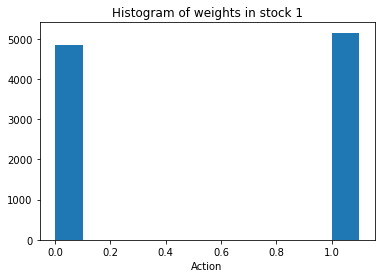

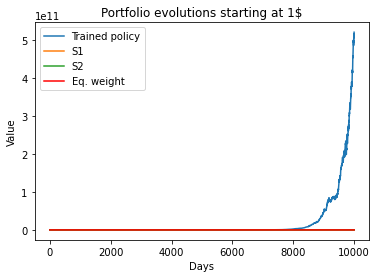

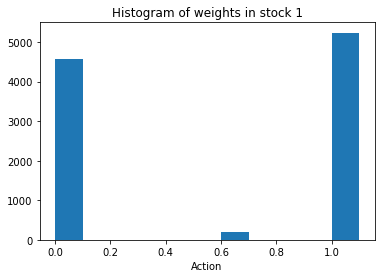

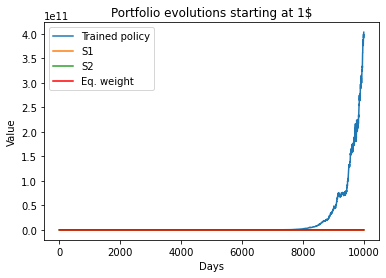

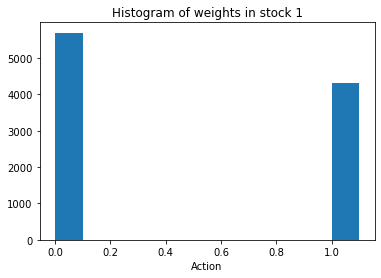

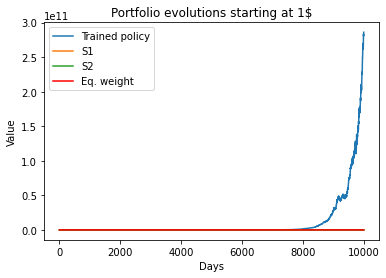

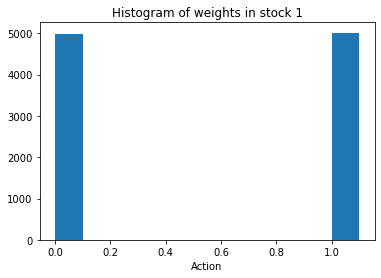

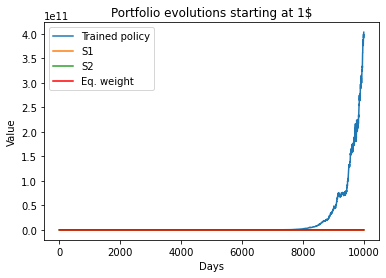

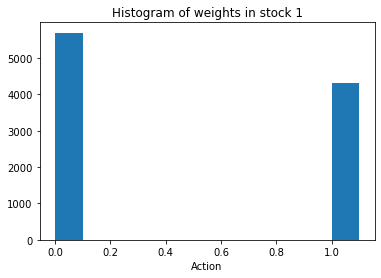

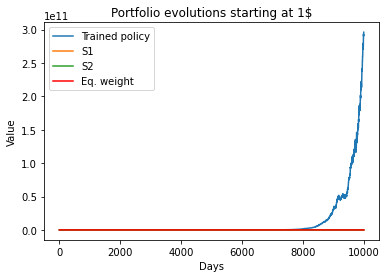

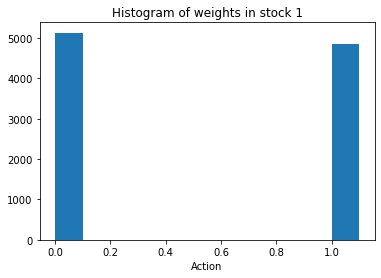

In [37]:
for j in jobs_QL_del:
    plot_result(j['exploit_test'])

In [38]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for decay_rate in [1,0.1,0.01]:
        for w in [1,2]:
            params.extend([create_param_QLearning(pd.DataFrame(discretize(ar_corrtrain_del), index=['S1','S2']), np.array(discretize(ar_corrtest_del)),  window=w, decay_rate=decay_rate,adaptive_lr=True)])

    jobs_QL_del_adaptlr = pool.map(multi_train_QLearning, params)
    

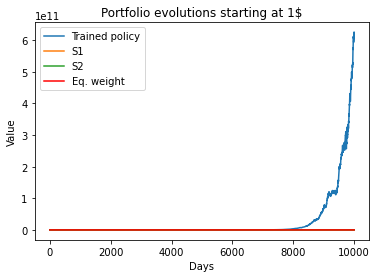

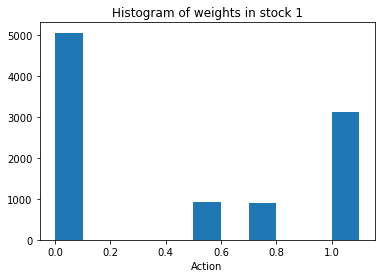

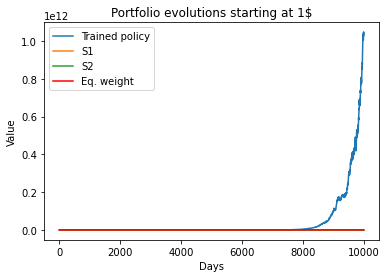

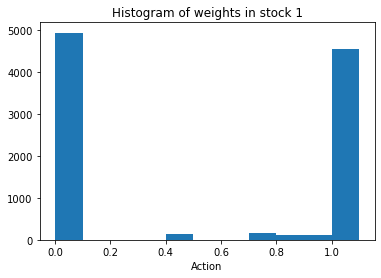

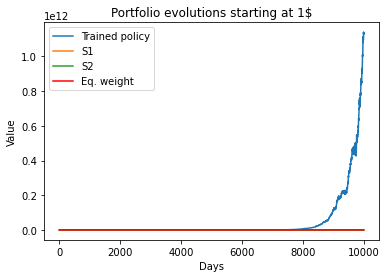

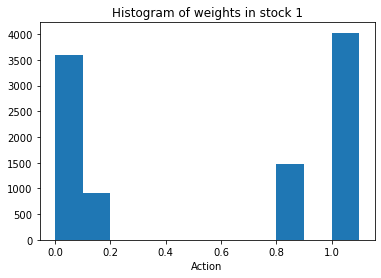

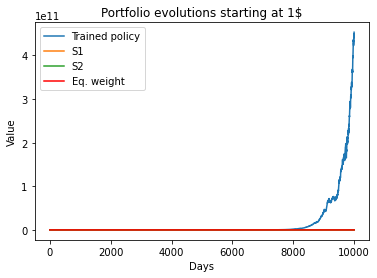

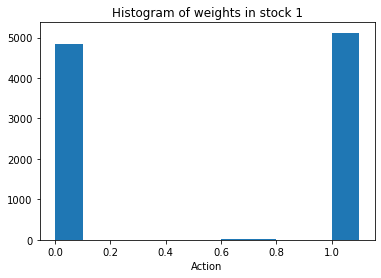

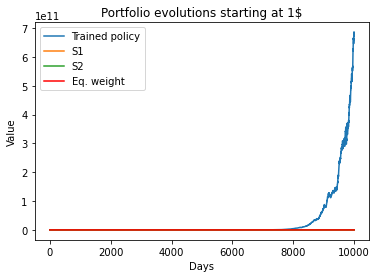

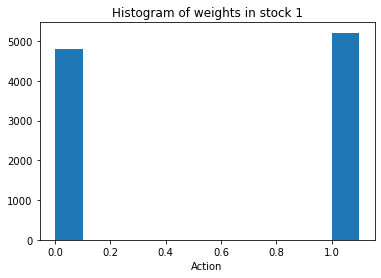

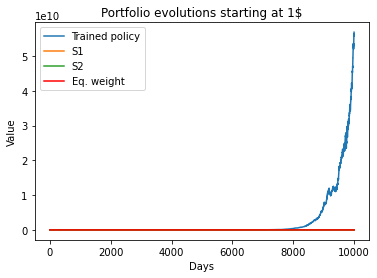

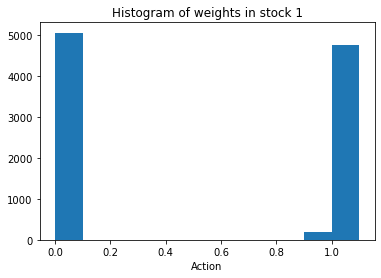

In [39]:
for j in jobs_QL_del_adaptlr:
    plot_result(j['exploit_test'])

# Deep Q-Network

In [40]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,256]:
            for w in [1,2]:
                params.extend([create_param_DQN(pd.DataFrame(ar_corrtrain_del),ar_corrtest_del, window=w,batch_size=batch_size,lr=lr,true_qval=None)])

    jobs_del = pool.map(multi_train, params)
    

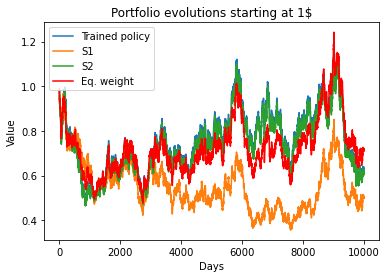

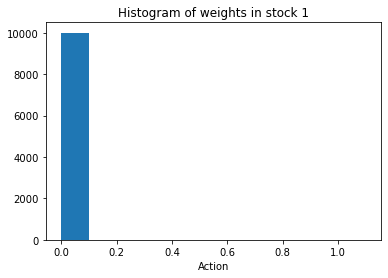

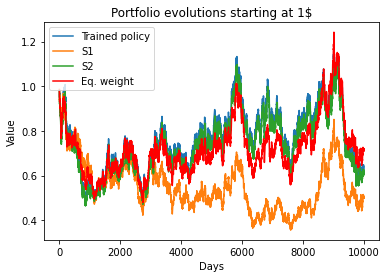

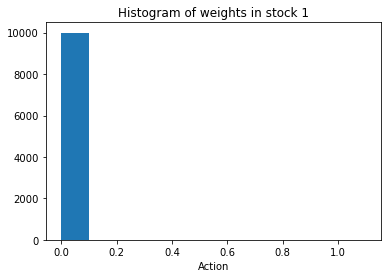

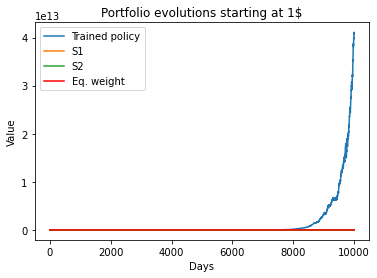

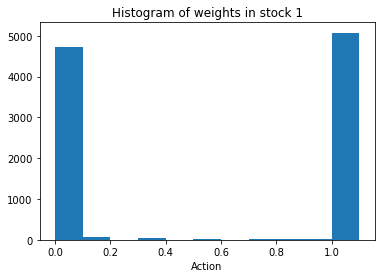

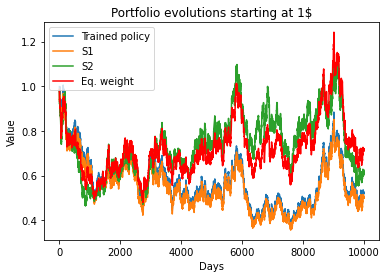

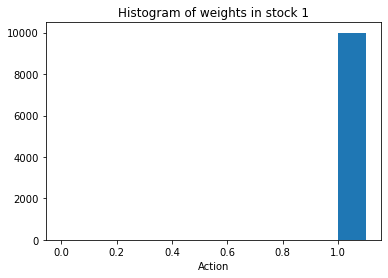

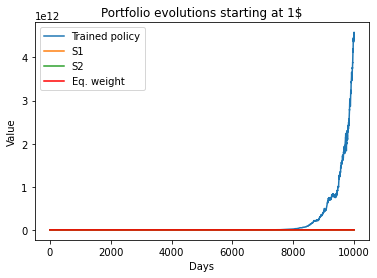

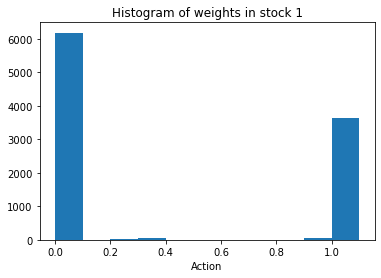

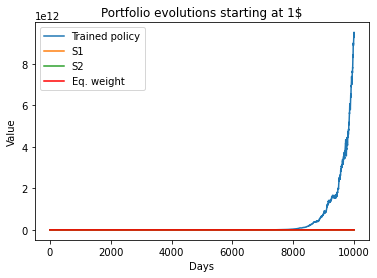

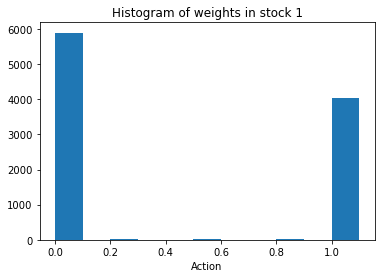

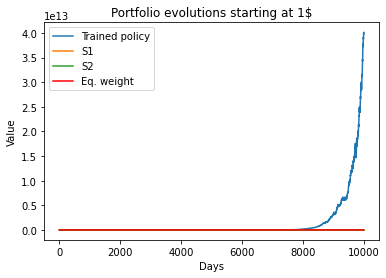

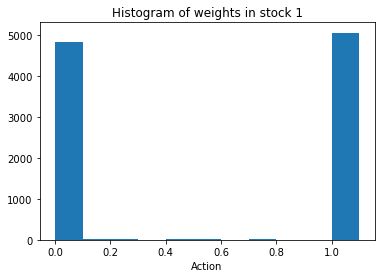

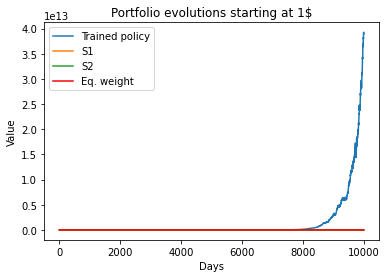

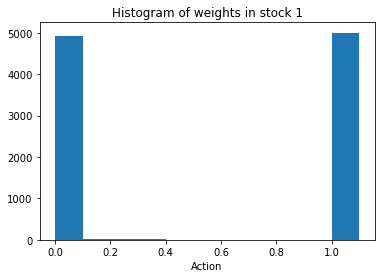

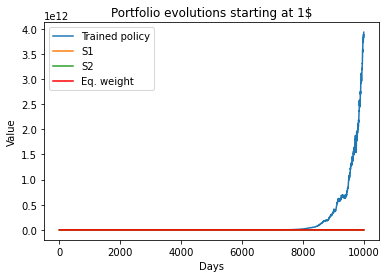

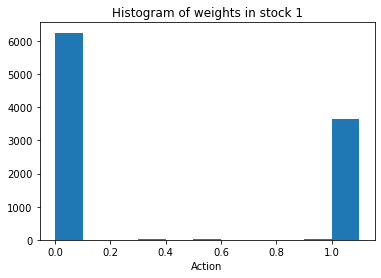

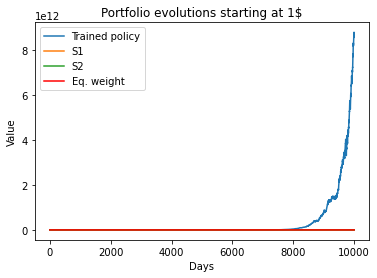

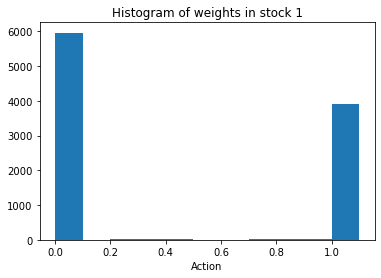

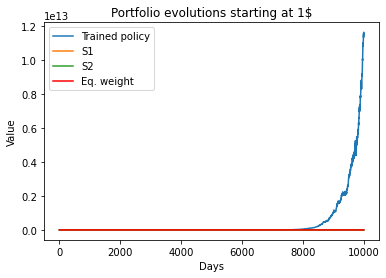

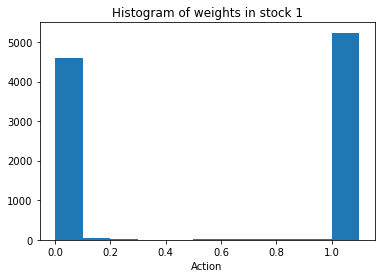

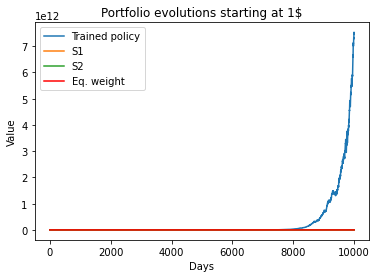

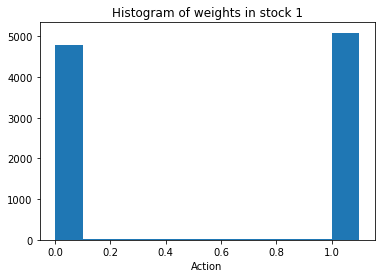

In [41]:
for j in jobs_del:
    plot_result(j['exploit_test'])

In [42]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [1,0.1,0.01]:
        for tau in [1,0.4]:
            for w in [1,2]:
                params.extend([create_param_DQN(pd.DataFrame(ar_corrtrain_del),ar_corrtest_del, window=w,lr=lr,tau=tau,true_qval=None,adaptive_lr=True)])

    jobs_del_adaptlr = pool.map(multi_train, params)
    

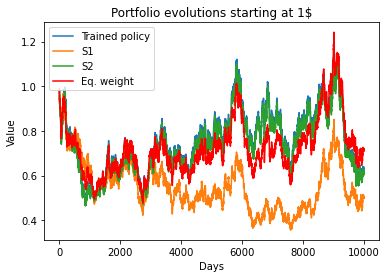

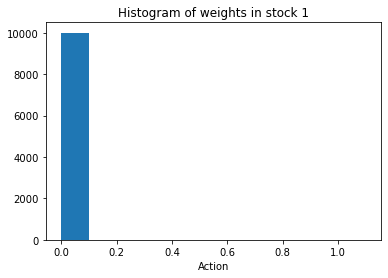

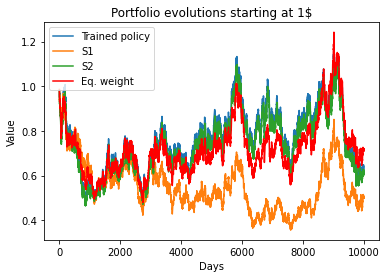

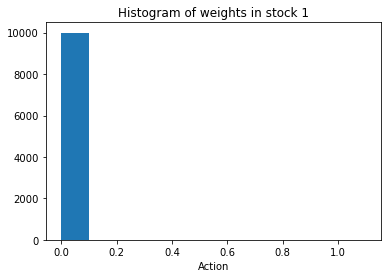

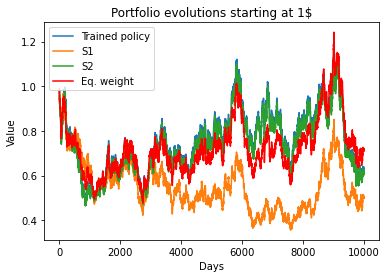

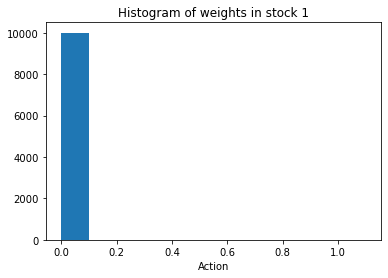

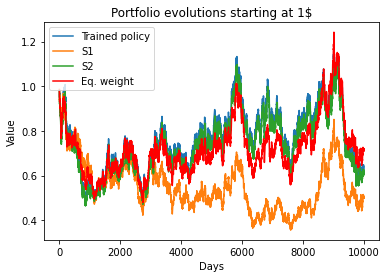

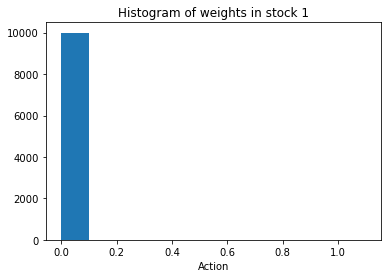

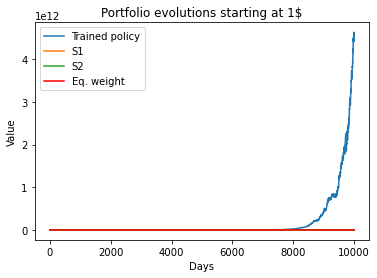

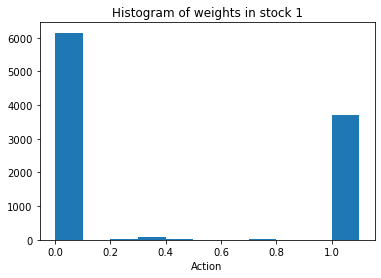

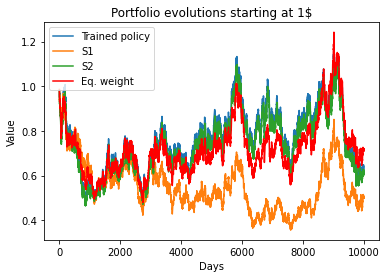

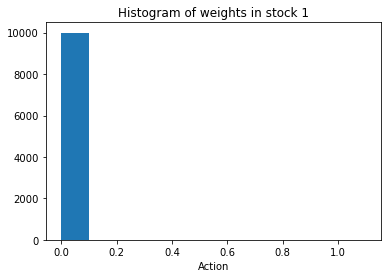

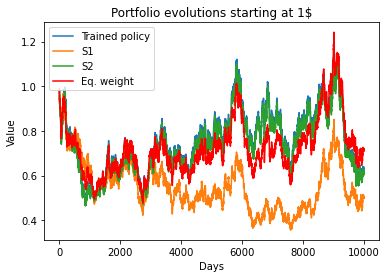

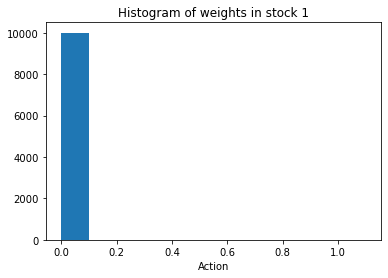

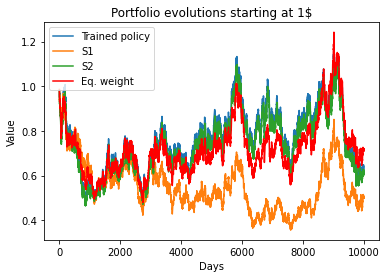

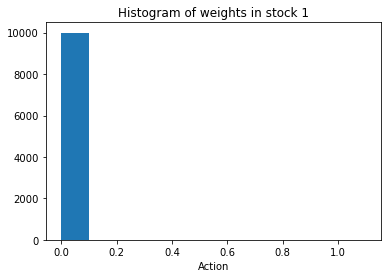

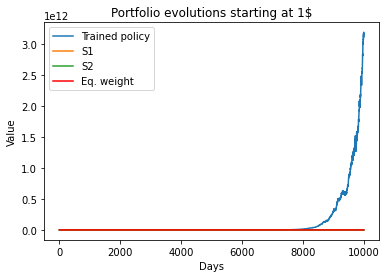

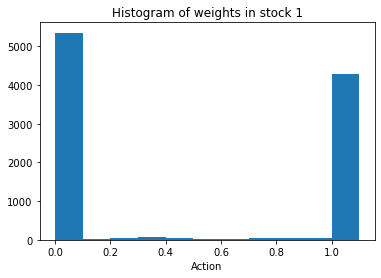

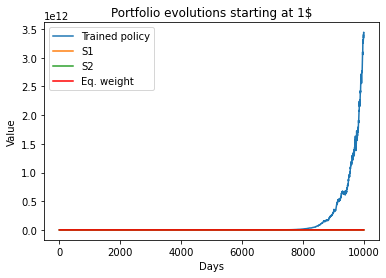

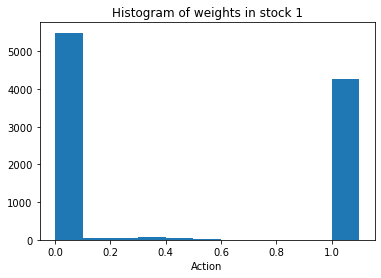

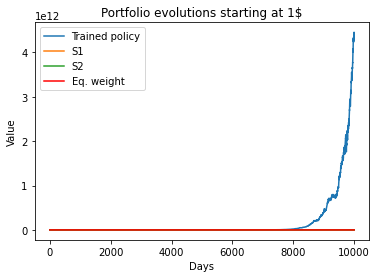

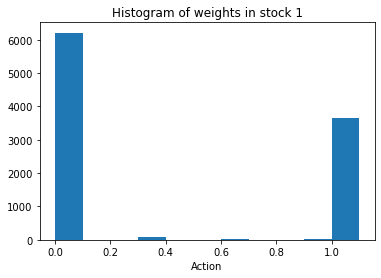

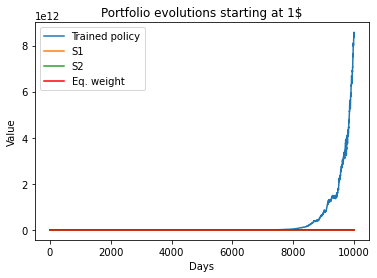

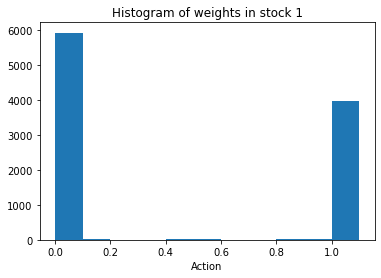

In [43]:
for j in jobs_del_adaptlr:
    plot_result(j['exploit_test'])

In [111]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [1,0.1,0.01]:
        for tau in [1,0.4]:
            for w in [1,2]:
                params.extend([create_param_DQN(pd.DataFrame(ar_corrtrain_del),ar_corrtest_del, window=w,batch_size=256,lr=lr,tau=tau,true_qval=None,adaptive_lr=True)])

    jobs_del_adaptlr_256 = pool.map(multi_train, params)
    

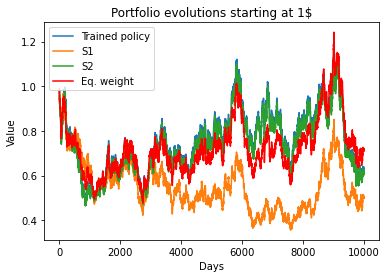

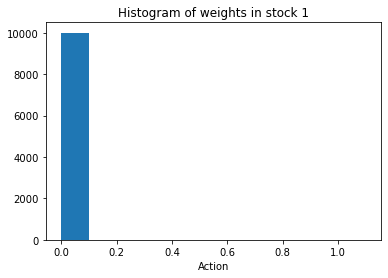

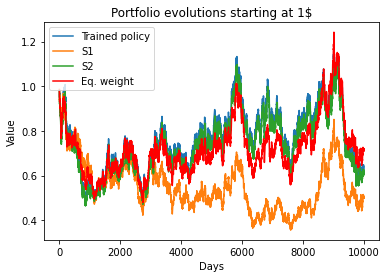

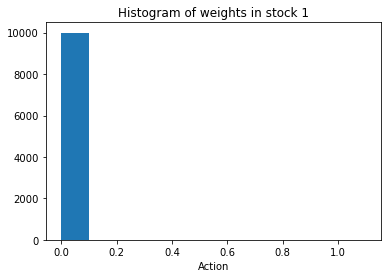

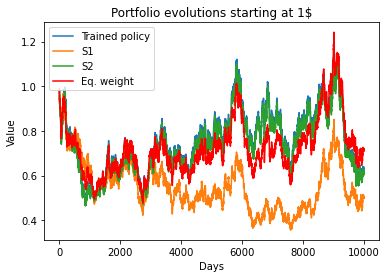

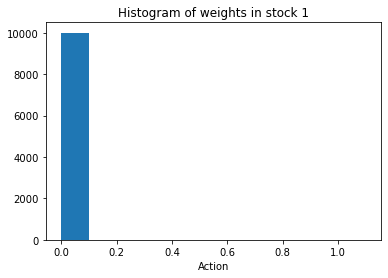

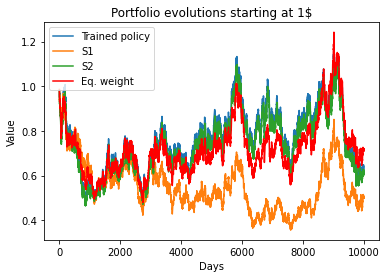

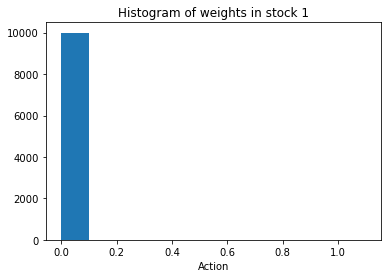

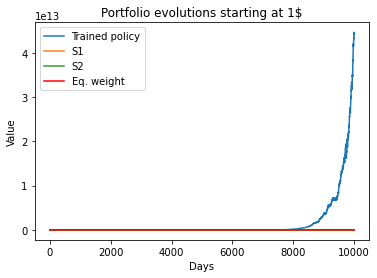

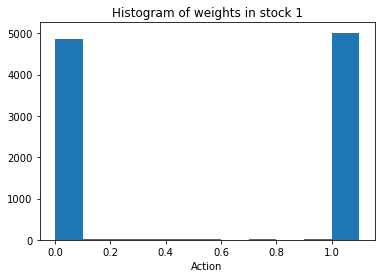

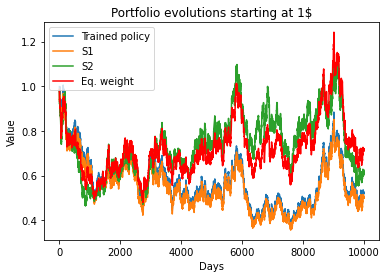

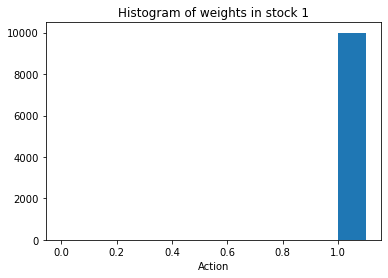

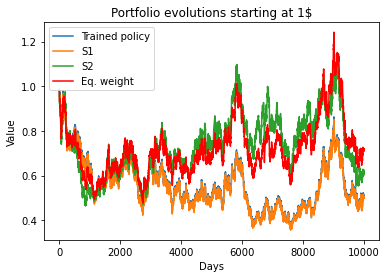

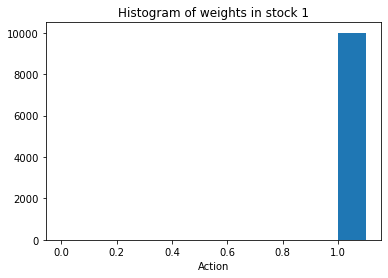

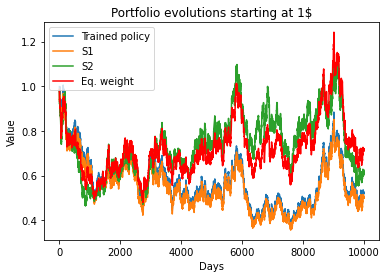

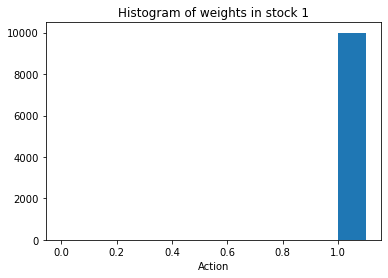

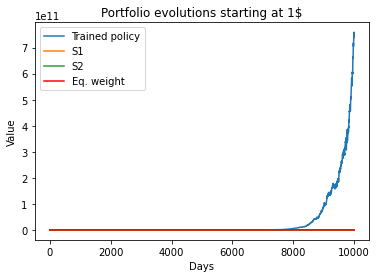

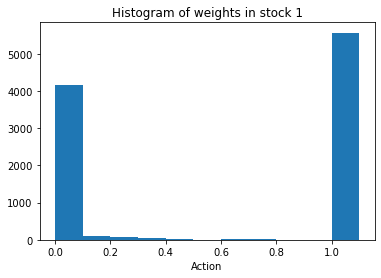

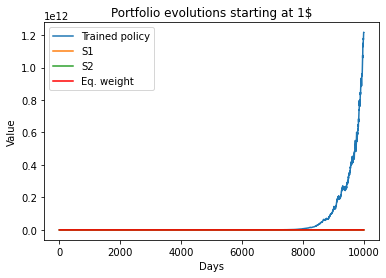

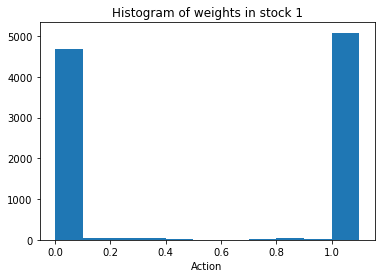

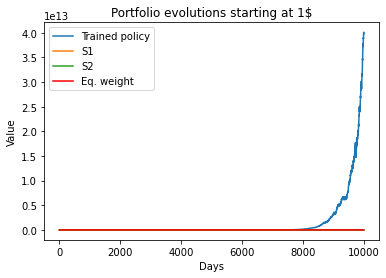

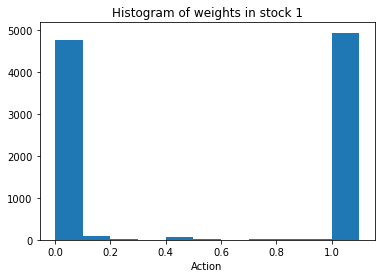

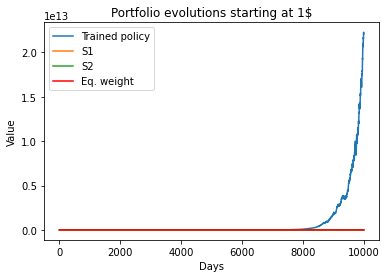

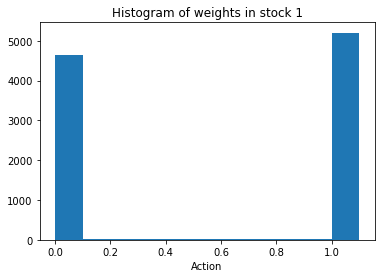

In [112]:
for j in jobs_del_adaptlr_256:
    plot_result(j['exploit_test'])

In [113]:
PROCESSES = 4
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.001,0.0001]:
        for tau in [1,0.4]:
            for w in [1,2]:
                params.extend([create_param_DQN(pd.DataFrame(ar_corrtrain_del),ar_corrtest_del, window=w,batch_size=256,lr=lr,tau=tau,true_qval=None,adaptive_lr=True)])

    jobs_del_adaptlr_001 = pool.map(multi_train, params)
    

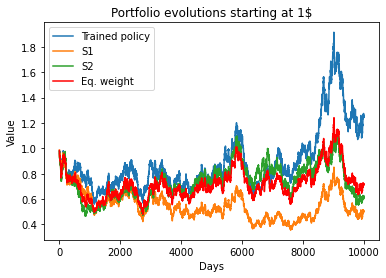

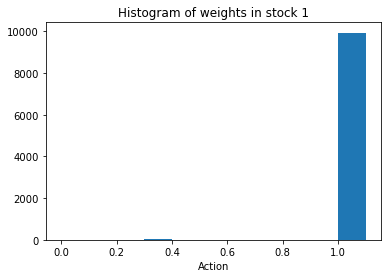

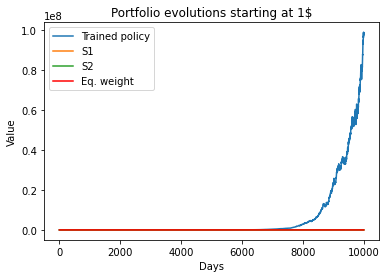

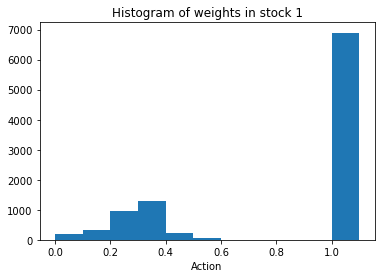

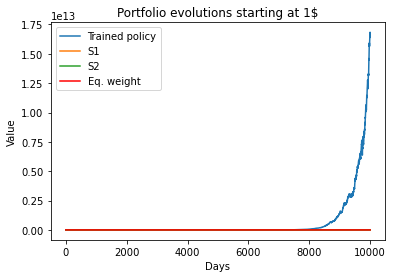

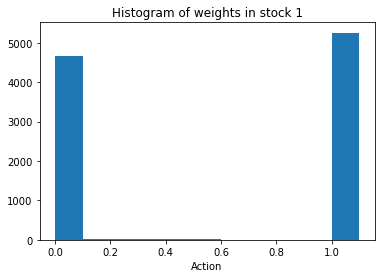

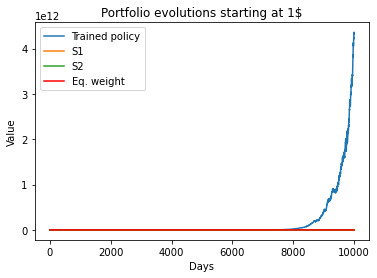

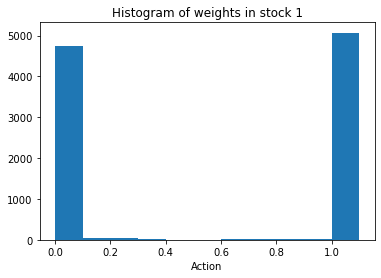

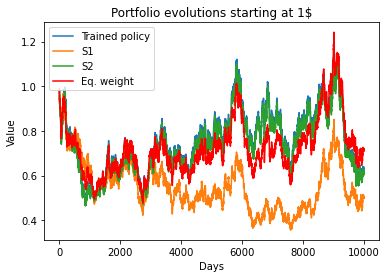

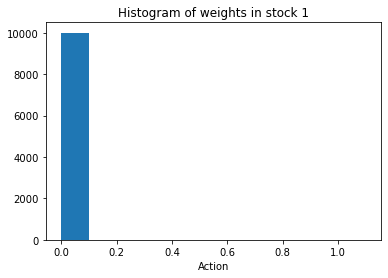

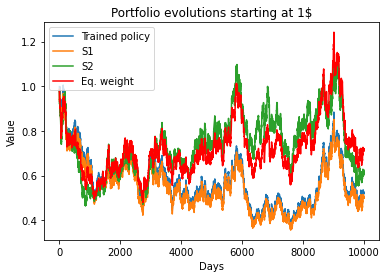

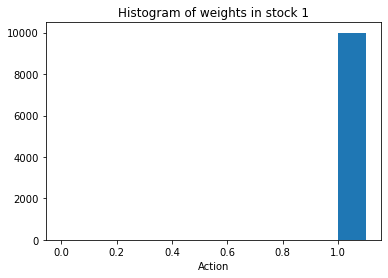

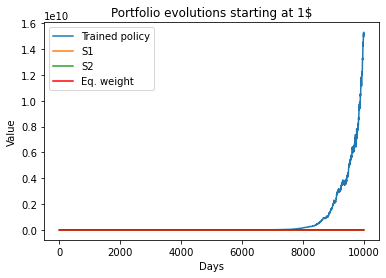

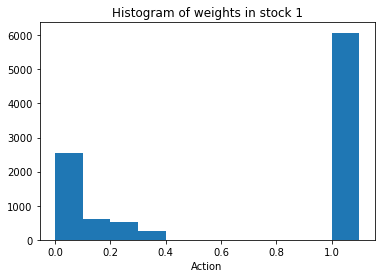

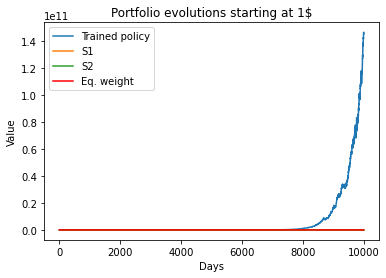

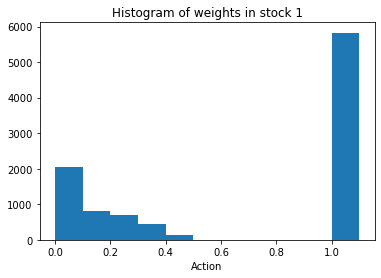

In [114]:
for j in jobs_del_adaptlr_001:
    plot_result(j['exploit_test'])

# Policies close to optimality can be learned for a lot of different parameters.

#### Simple learning rate:
Choosing $\alpha$ between $0.001$ and $0.00001$ ensures very good performance on the testing data, as weel as for $w=1$, $\alpha=0.01$ and batch size of $256$.

#### Adaptive learning rate:
For low $\alpha$ and batch size $256$, it seems that setting parameter $\tau=0.4$ leads to better performance while $\tau=1$ often leads to divergence.

# Higher value for $\theta_1=0.1$ while keeping $\theta_0=0.01$ and no correlation

This induces a higher dependence on the previous return. The discretized optimal policy equals:

\begin{equation*}
    \pi^\star_{\text{discr.}}(a_t \mid s_t) = \begin{cases}
        1.0, \qquad &\text{ if } d(r_{1,t}) > d(r_{2,t})\\
        0.0, \qquad &\text{ if } d(r_{1,t}) < d(r_{2,t})\\
        0.5, \qquad &\text{ if } d(r_{1,t}) = d(r_{2,t})
    \end{cases}
\end{equation*}

where $d$ denotes the discretization routine.

In the continuous context, the action $0.5$ is false since there will never be a time-step for which $r_{1,t}=r_{2,t}$.

In [44]:
np.random.seed(921942)
ar_cdel=ARProcess2d([0.01,0.1],corr=0)
Nsim=100000
Ntest=10000
ar_dat=np.exp(ar_cdel.simulate(Nsim))
ar_test=np.exp(ar_cdel.simulate(Ntest))


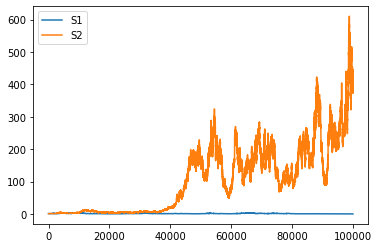

In [45]:
plt.plot(np.cumprod(ar_dat.iloc[0,:]))
plt.plot(np.cumprod(ar_dat.iloc[1,:]))
plt.legend(['S1','S2'])
plt.show()

In [5]:
true_qval_ar3=ar_cdel.discrete_true_qval(1e-5)

Time needed to converge with delta =  1e-05  :  202


### Performance of discretized optimal policy

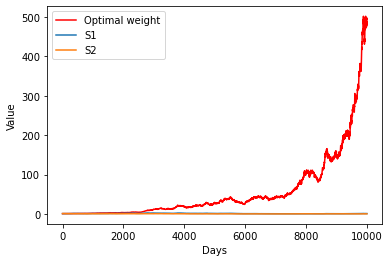

In [46]:
w_opt_ar3=exploit_optimal(true_qval_ar3, discretize(ar_test),window=1)
ret_opt_ar3 = np.sum(w_opt_ar3 * ar_test.iloc[:, 1:], axis=0)
plt.plot(np.cumprod(ret_opt_ar3),'red')
plt.plot(np.cumprod(ar_test.iloc[0,1:]))
plt.plot(np.cumprod(ar_test.iloc[1,:]))
plt.legend(['Optimal weight', 'S1','S2'])
plt.xlabel('Days')
plt.ylabel('Value')
plt.show()

## Q-Learning

In [69]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for decay_rate in [0.01,0.001,0.0001]:
        for tau in [1,0.7]:
            params.extend([create_param_QLearning(discretize(ar_dat), np.array(discretize(ar_test)),  window=1, decay_rate=decay_rate,tau=tau,true_qval = true_qval_ar3)])

    jobs_QL_theta1 = pool.map(multi_train_QLearning, params)
    


 

Simple learning rate: Decay rate : 0.01, Beta : 0, Tau : 1


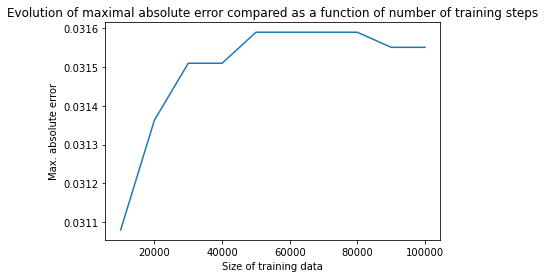

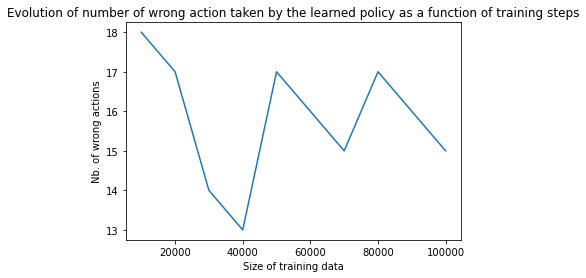


 Wrong actions : 
There are a lot of wrong actions :  15


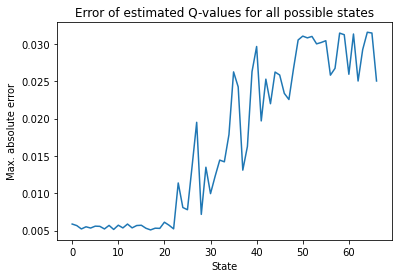


 

Simple learning rate: Decay rate : 0.01, Beta : 0, Tau : 0.7


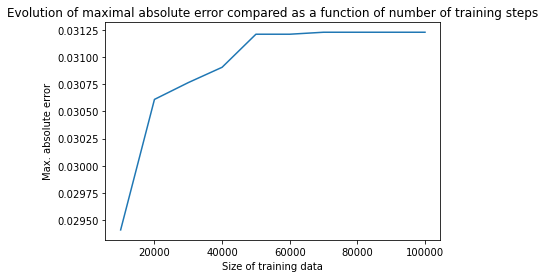

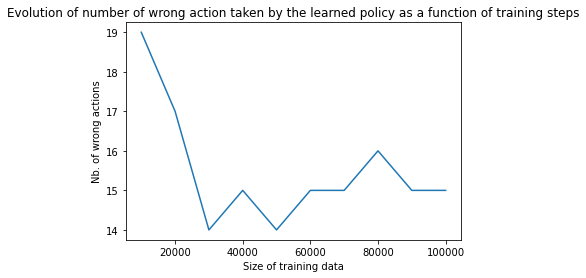


 Wrong actions : 
There are a lot of wrong actions :  15


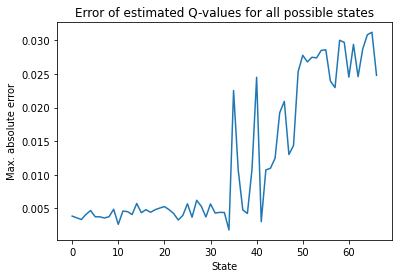


 

Simple learning rate: Decay rate : 0.001, Beta : 0, Tau : 1


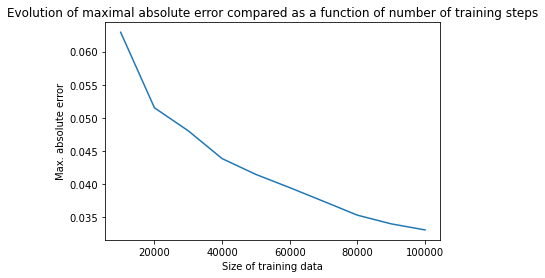

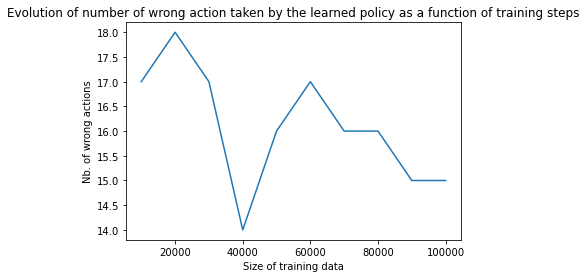


 Wrong actions : 
There are a lot of wrong actions :  15


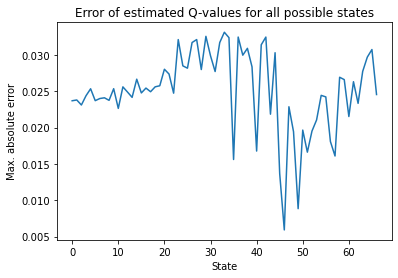


 

Simple learning rate: Decay rate : 0.001, Beta : 0, Tau : 0.7


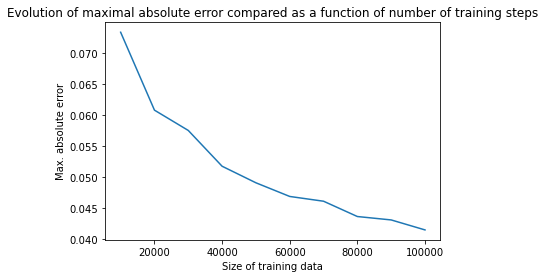

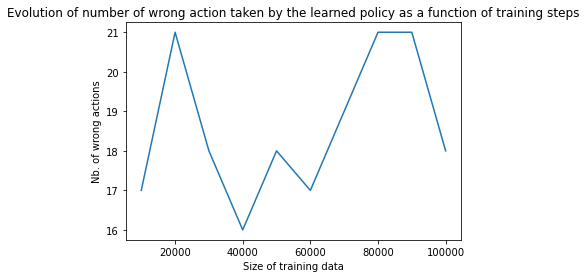


 Wrong actions : 
There are a lot of wrong actions :  18


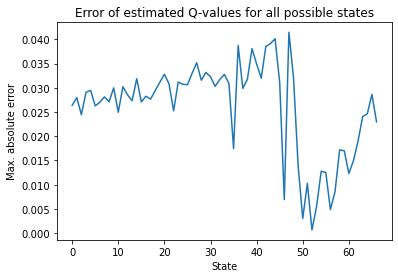


 

Simple learning rate: Decay rate : 0.0001, Beta : 0, Tau : 1


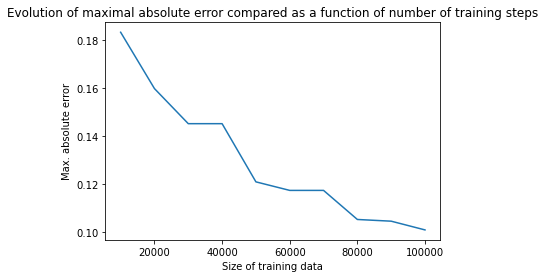

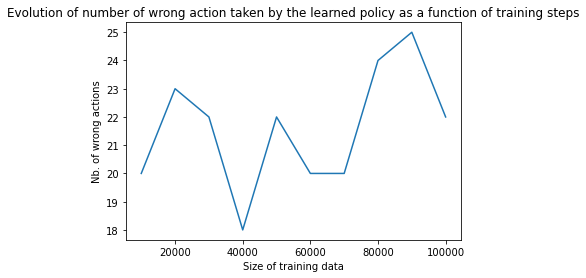


 Wrong actions : 
There are a lot of wrong actions :  22


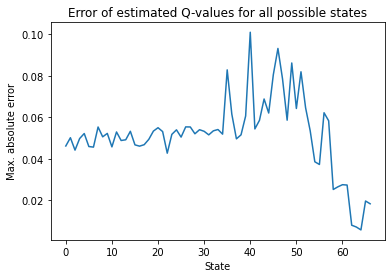


 

Simple learning rate: Decay rate : 0.0001, Beta : 0, Tau : 0.7


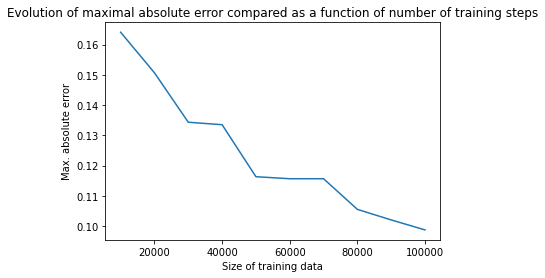

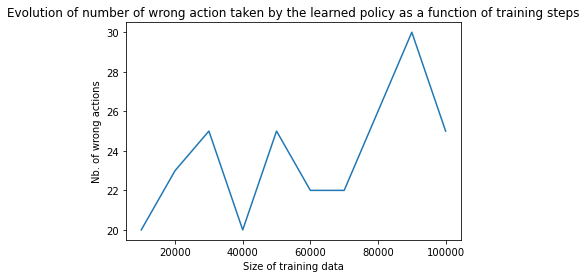


 Wrong actions : 
There are a lot of wrong actions :  25


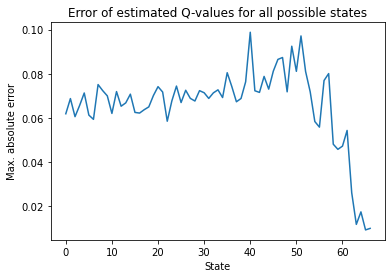

In [70]:
for x in jobs_QL_theta1:
    plot_res_multi_QLearning(x,true_qval_ar3)

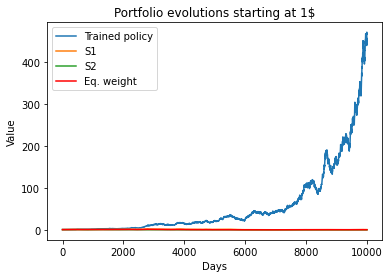

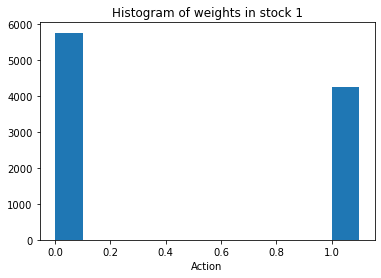

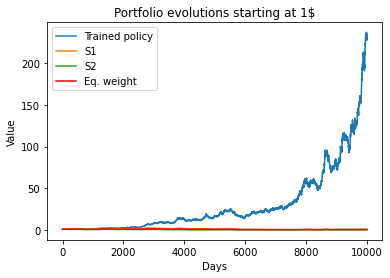

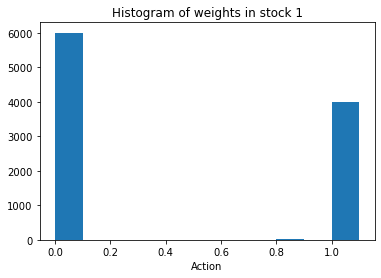

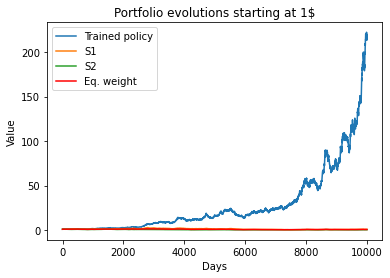

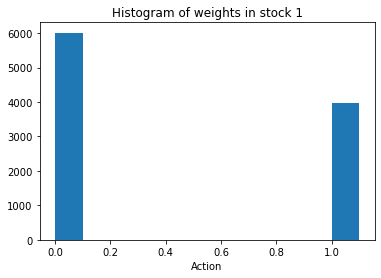

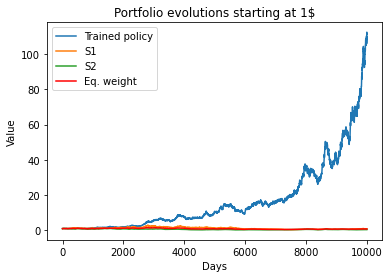

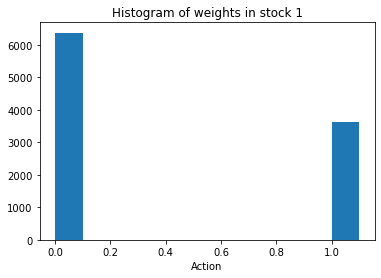

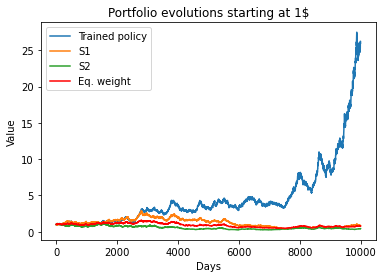

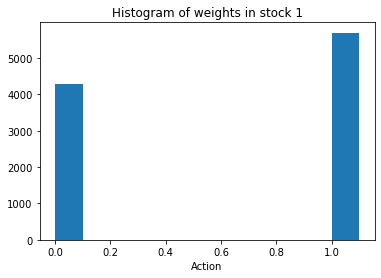

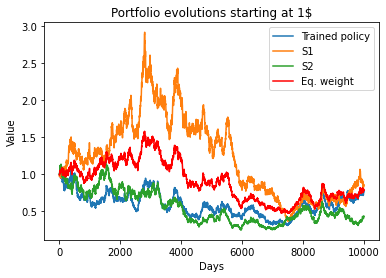

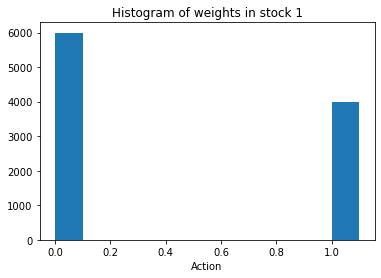

In [71]:
for x in jobs_QL_theta1:
    plot_result(x['exploit_test'])

In [72]:
for k in jobs_QL_theta1[0]['q_val'].keys():
    if np.argmax(jobs_QL_theta1[0]['q_val'][k]) != np.argmax(true_qval_ar3[k]):
        print(k, ' Optimal action : ',np.argmax(true_qval_ar3[k]), '; Learned action : ', np.argmax(jobs_QL_theta1[0]['q_val'][k]))

[0.99, 0.99]  Optimal action :  5 ; Learned action :  10
[1.0, 1.0]  Optimal action :  5 ; Learned action :  0
[1.01, 1.01]  Optimal action :  5 ; Learned action :  0
[1.0, 0.97]  Optimal action :  10 ; Learned action :  0
[1.02, 1.02]  Optimal action :  5 ; Learned action :  0
[0.98, 0.98]  Optimal action :  5 ; Learned action :  10
[1.0, 1.03]  Optimal action :  0 ; Learned action :  10
[1.03, 1.01]  Optimal action :  10 ; Learned action :  0
[0.97, 0.97]  Optimal action :  5 ; Learned action :  0
[1.03, 0.97]  Optimal action :  10 ; Learned action :  0
[1.03, 1.03]  Optimal action :  5 ; Learned action :  0
[0.98, 0.96]  Optimal action :  10 ; Learned action :  0
[1.02, 0.96]  Optimal action :  10 ; Learned action :  0
[1.02, 1.04]  Optimal action :  0 ; Learned action :  10
[1.04, 0.98]  Optimal action :  10 ; Learned action :  0


In [73]:
for k in jobs_QL_theta1[1]['q_val'].keys():
    if np.argmax(jobs_QL_theta1[1]['q_val'][k]) != np.argmax(true_qval_ar3[k]):
        print(k, ' Optimal action : ',np.argmax(true_qval_ar3[k]), '; Learned action : ', np.argmax(jobs_QL_theta1[1]['q_val'][k]))

[0.99, 0.99]  Optimal action :  5 ; Learned action :  0
[1.0, 1.0]  Optimal action :  5 ; Learned action :  0
[1.01, 1.01]  Optimal action :  5 ; Learned action :  10
[1.02, 1.0]  Optimal action :  10 ; Learned action :  0
[1.02, 1.02]  Optimal action :  5 ; Learned action :  10
[0.98, 0.98]  Optimal action :  5 ; Learned action :  10
[0.99, 0.97]  Optimal action :  10 ; Learned action :  8
[0.97, 0.97]  Optimal action :  5 ; Learned action :  0
[1.04, 0.99]  Optimal action :  10 ; Learned action :  0
[1.03, 0.97]  Optimal action :  10 ; Learned action :  0
[1.03, 1.03]  Optimal action :  5 ; Learned action :  0
[0.98, 0.96]  Optimal action :  10 ; Learned action :  0
[1.02, 0.96]  Optimal action :  10 ; Learned action :  0
[1.02, 1.04]  Optimal action :  0 ; Learned action :  10
[1.04, 0.98]  Optimal action :  10 ; Learned action :  0


### Performance pretty good for simple learning rate with $\lambda=0.01$ and $\tau=1$ or $\tau=0.7$

## Deep Q-Networks

In [11]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


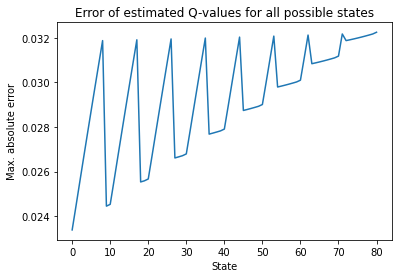


 

 Parameters are : lr = 0.01, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


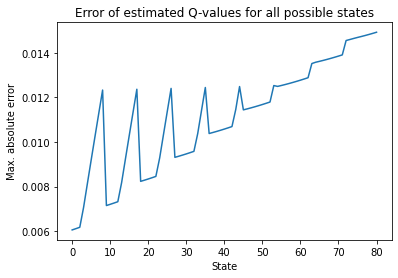


 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


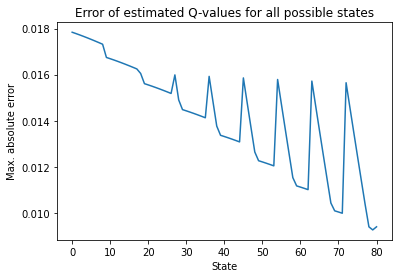


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


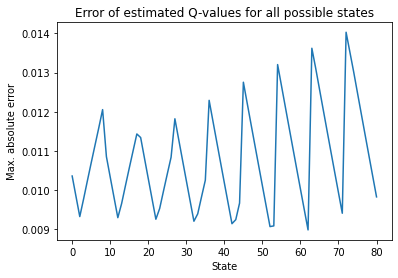


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


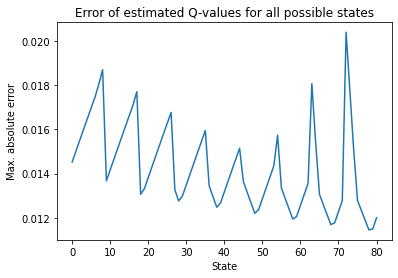


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


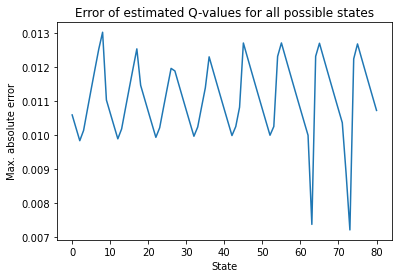

In [12]:
for j in jobs_ar3:
    plot_res_from_multi(j,true_qval_ar3)

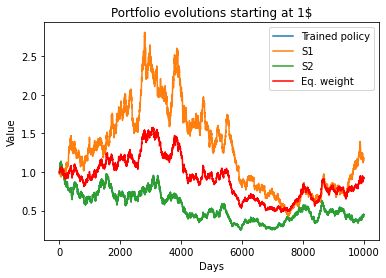

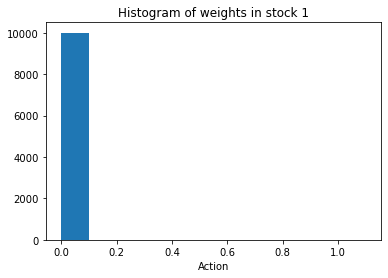

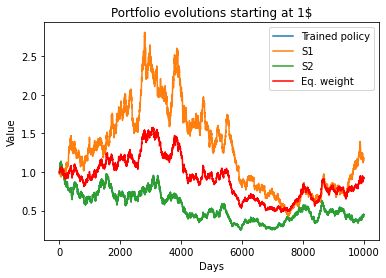

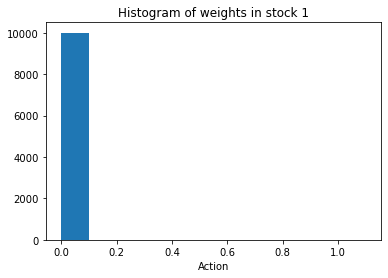

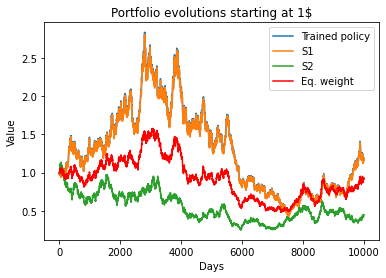

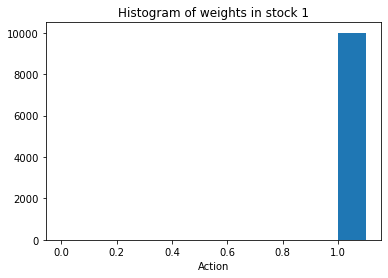

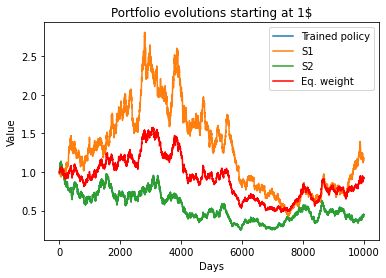

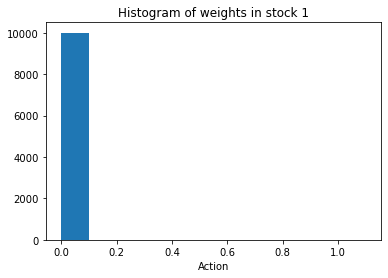

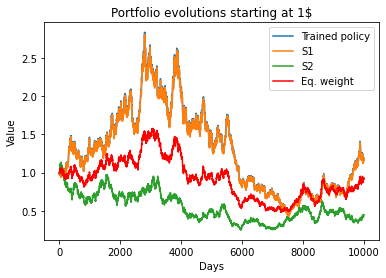

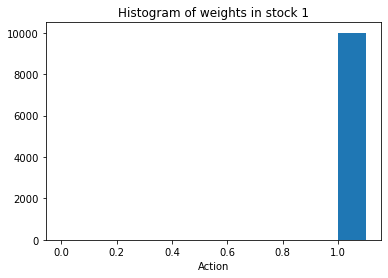

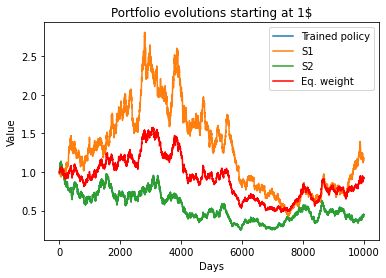

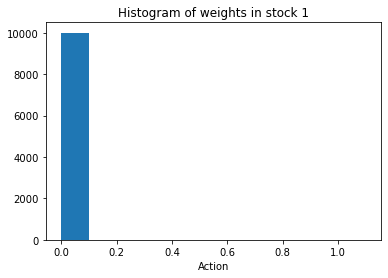

In [13]:
for x in jobs_ar3:
    plot_result(x['exploit_test'])

In [17]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.001,0.0001]:
        for batch_size in [32,54,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr_smaller = pool.map(multi_train, params)



 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


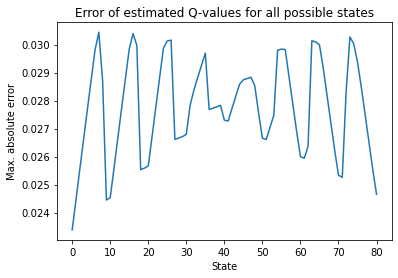


 

 Parameters are : lr = 0.001, window = 1, batch size = 54, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


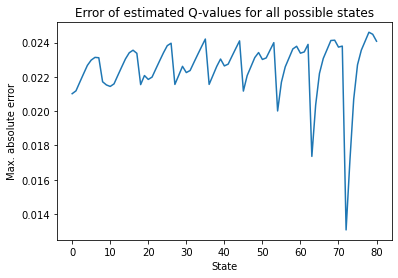


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


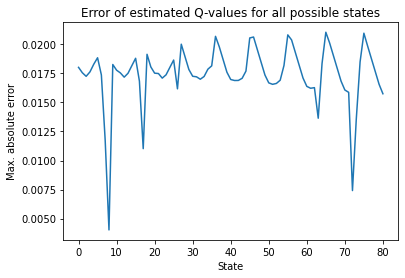


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


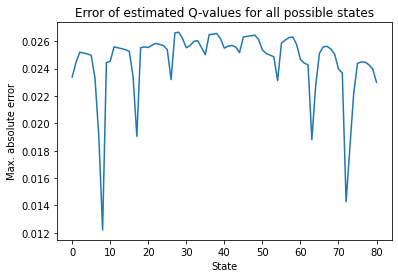


 

 Parameters are : lr = 0.0001, window = 1, batch size = 54, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


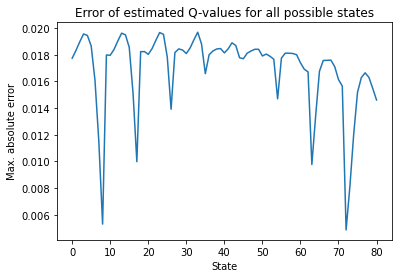


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


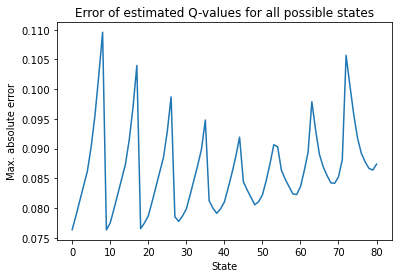

In [18]:
for j in jobs_ar3_adaptlr_smaller:
    plot_res_from_multi(j,true_qval_ar3)

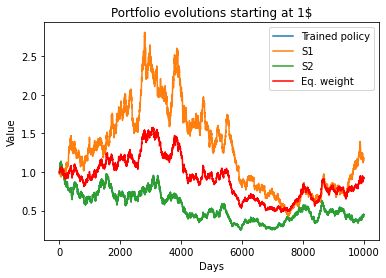

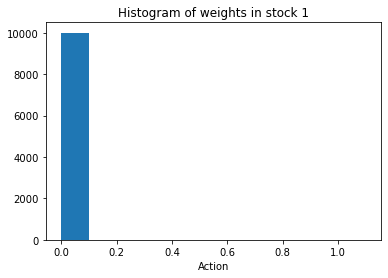

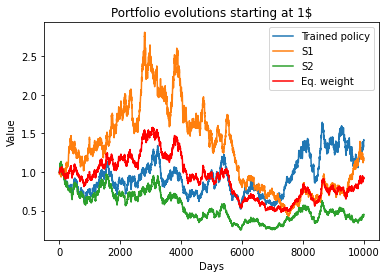

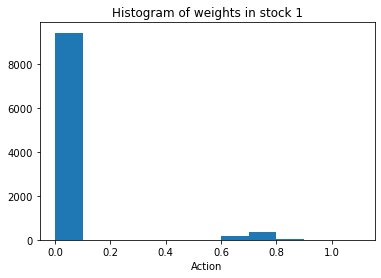

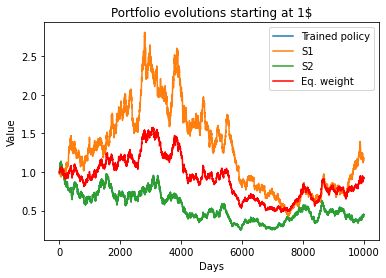

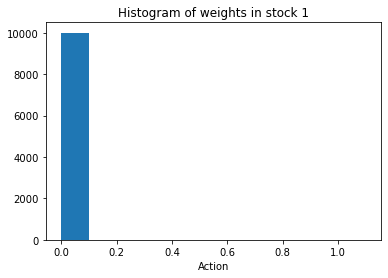

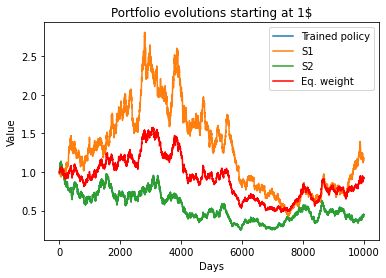

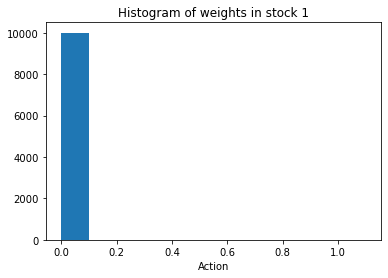

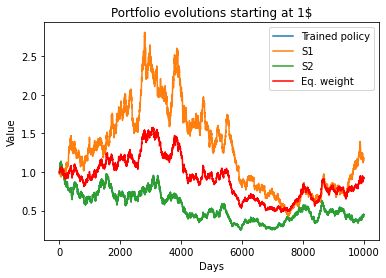

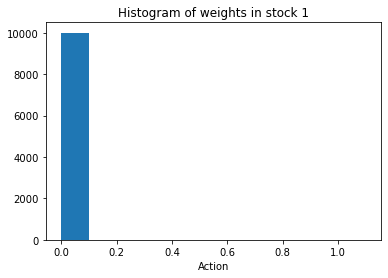

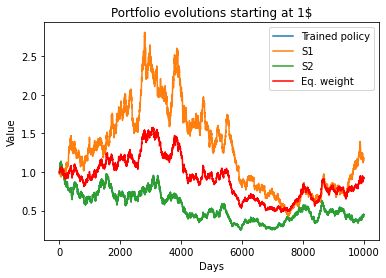

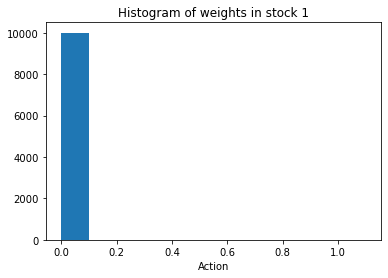

In [19]:
for x in jobs_ar3_adaptlr_smaller:
    plot_result(x['exploit_test'])

In [20]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.00001,0.000001]:
        for batch_size in [64,128,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_smaller = pool.map(multi_train, params)



 

 Parameters are : lr = 1e-05, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  15


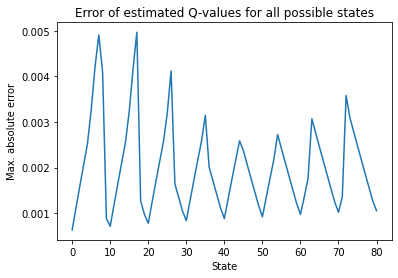


 

 Parameters are : lr = 1e-05, window = 1, batch size = 128, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  74


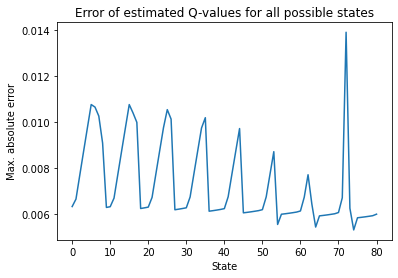


 

 Parameters are : lr = 1e-05, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


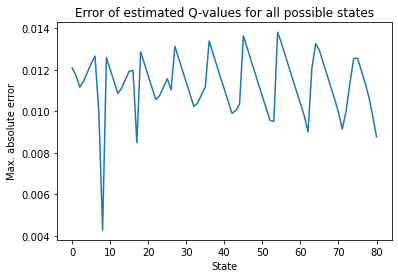


 

 Parameters are : lr = 1e-06, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


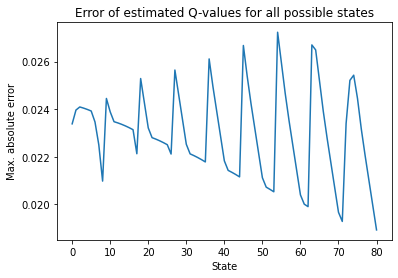


 

 Parameters are : lr = 1e-06, window = 1, batch size = 128, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


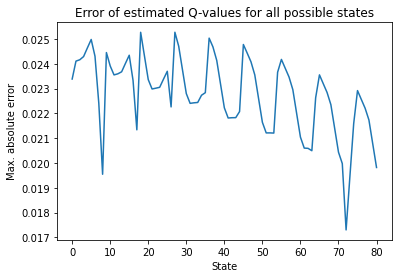


 

 Parameters are : lr = 1e-06, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


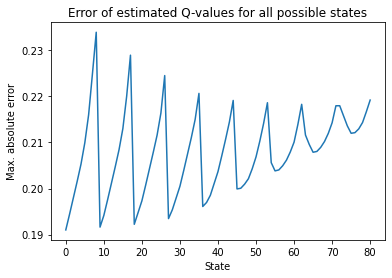

In [21]:
for j in jobs_ar3_smaller:
    plot_res_from_multi(j,true_qval_ar3)

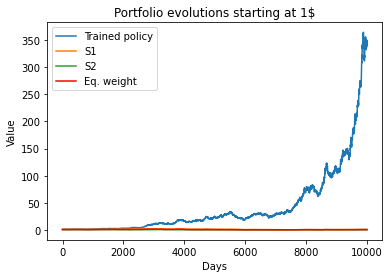

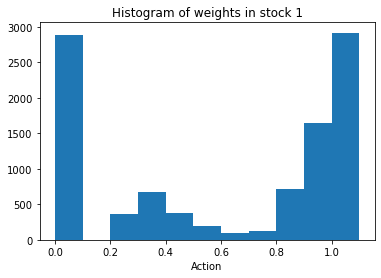

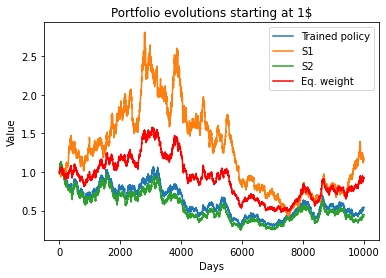

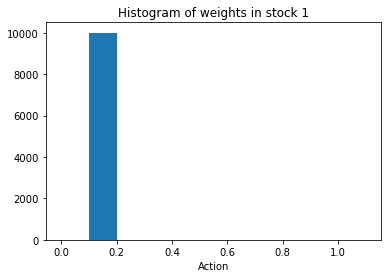

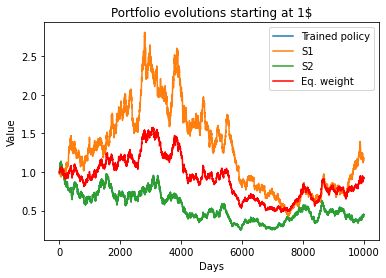

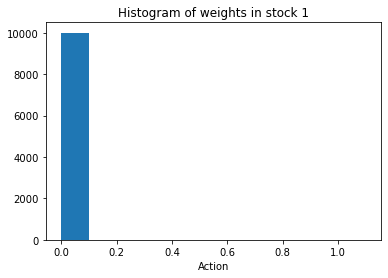

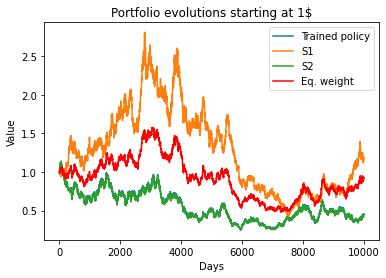

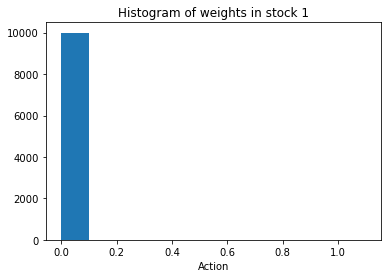

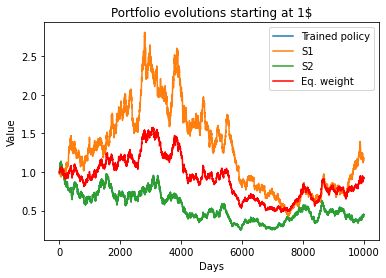

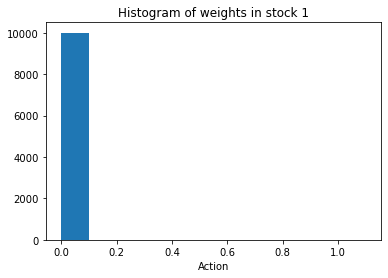

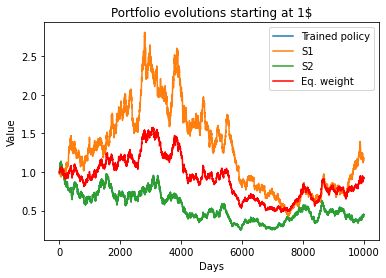

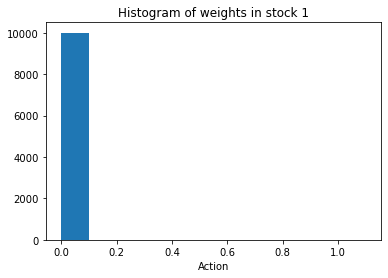

In [22]:
for x in jobs_ar3_smaller:
    plot_result(x['exploit_test'])

## Convergence is highly dependent on the choice of learning parameters.

Even when DQN learned for $\alpha=0.0001$ with batch size of $256$, the performance of the policy derived by DQN isn't so good (value of $350$) compared to the performance of discretized optimal policy (value of $500$). In addition, the best learned policy has $15$ wrong actions, but small maximal absolute error around $0.005$.

### Window $w=2$

In [23]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=2,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_w2 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


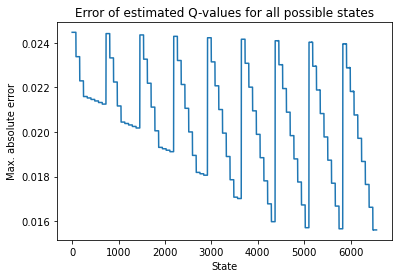


 

 Parameters are : lr = 0.01, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


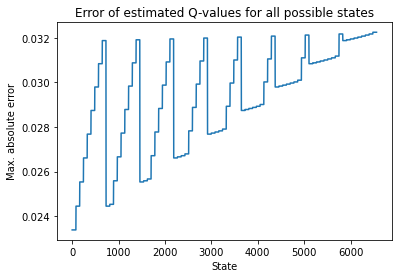


 

 Parameters are : lr = 0.001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


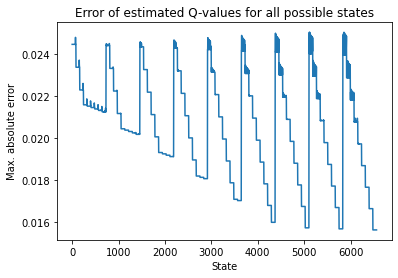


 

 Parameters are : lr = 0.001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  2173


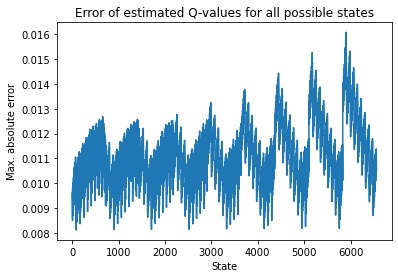


 

 Parameters are : lr = 0.0001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3489


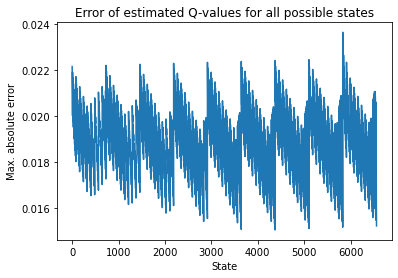


 

 Parameters are : lr = 0.0001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  752


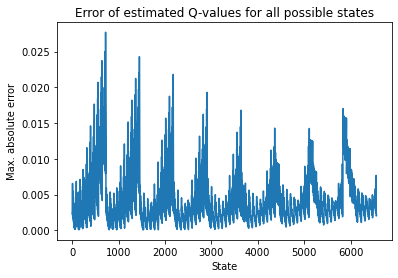

In [24]:
for j in jobs_ar3_w2:
    plot_res_from_multi(j,true_qval_ar3)

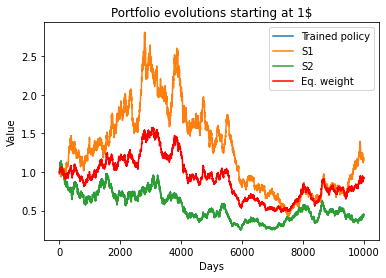

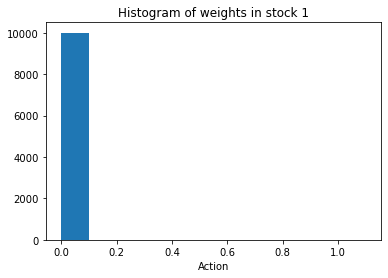

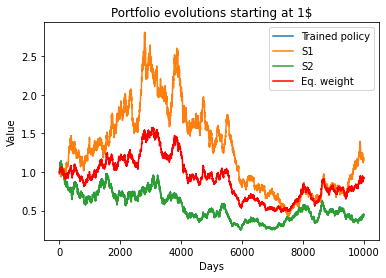

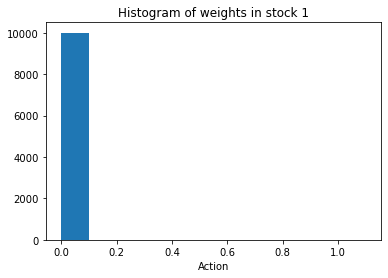

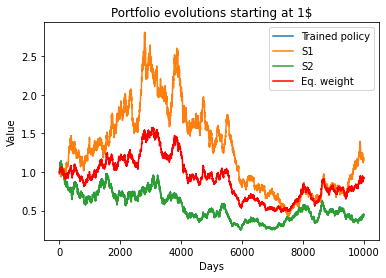

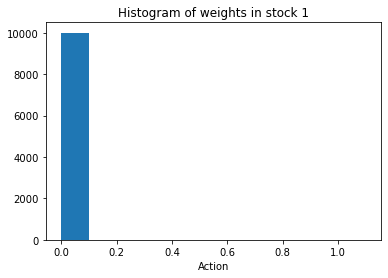

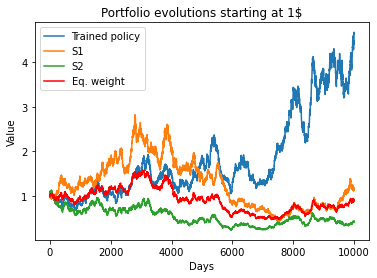

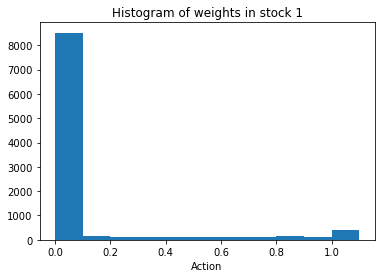

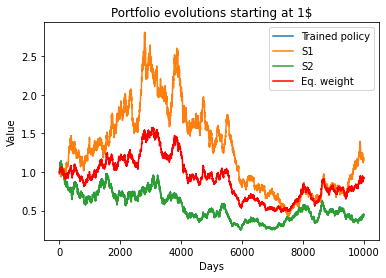

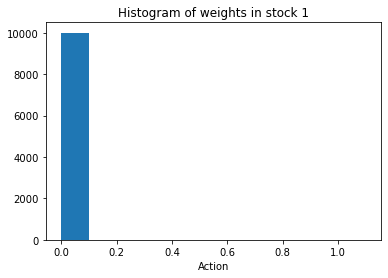

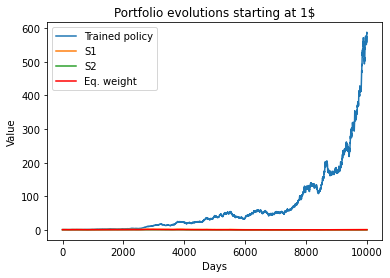

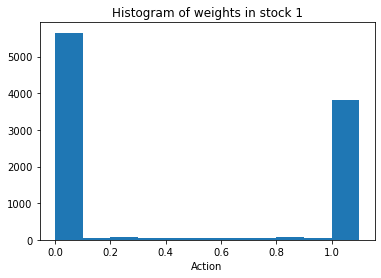

In [25]:
for x in jobs_ar3_w2:
    plot_result(x['exploit_test'])

## For $w=2$, DQN derived a really good policy which outperforms the discretized optimal policy.

In addition, $729$ of its $752$ wrong actions comes at state where both returns at current time-step have same discretized value, hence it only makes $23$ wrong actions over the $6561$ used as benchmark.

## Larger batch size $512$ for window $w=1$

We still want to derive a good choice of learning parameters.

In [47]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.1,0.01,0.001,0.0001,0.00001,0.000001]:
        for batch_size in [512]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_largerbatch = pool.map(multi_train, params)



 

 Parameters are : lr = 0.1, window = 1, batch size = 512, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  81


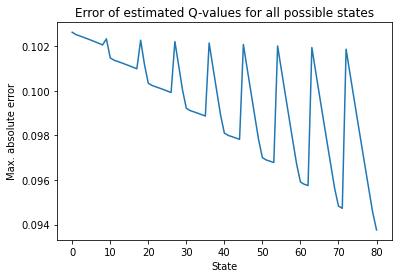


 

 Parameters are : lr = 0.01, window = 1, batch size = 512, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


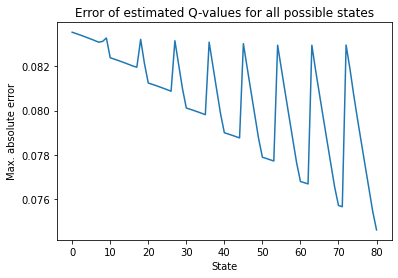


 

 Parameters are : lr = 0.001, window = 1, batch size = 512, nb. epochs = 100

 Wrong actions : 
[0.96, 0.96] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[0.97, 0.97] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[0.98, 0.98] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[0.99, 0.99] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.0, 1.0] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.01, 1.01] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.02, 1.02] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.03, 1.03] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.04, 1.04] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  9


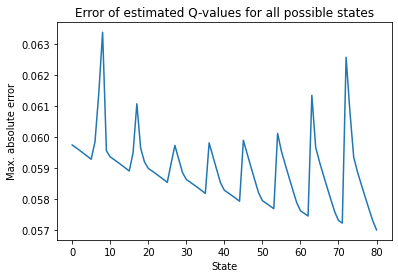


 

 Parameters are : lr = 0.0001, window = 1, batch size = 512, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


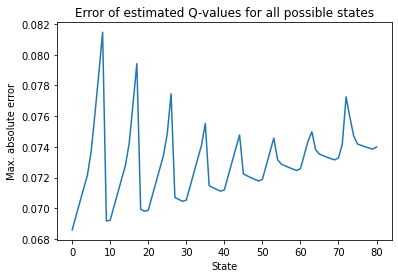


 

 Parameters are : lr = 1e-05, window = 1, batch size = 512, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


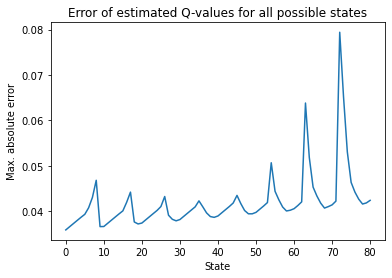


 

 Parameters are : lr = 1e-06, window = 1, batch size = 512, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


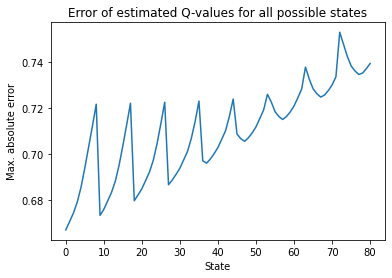

In [48]:
for j in jobs_ar3_largerbatch:
    plot_res_from_multi(j,true_qval_ar3)

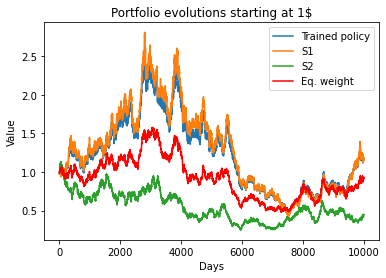

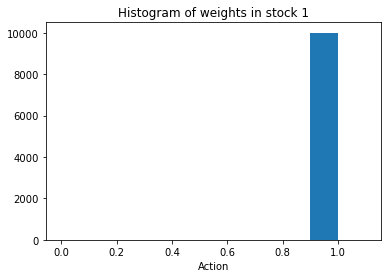

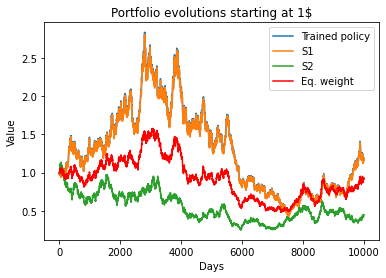

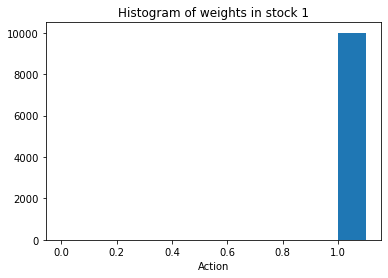

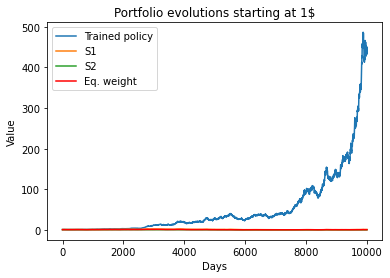

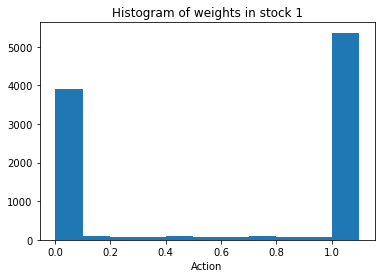

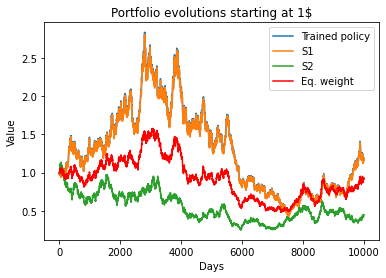

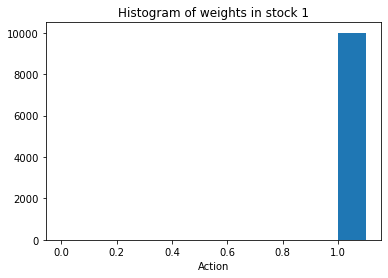

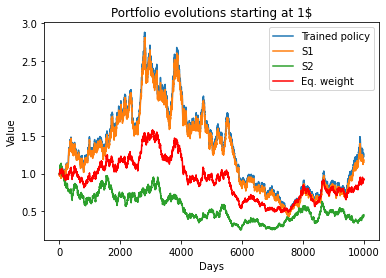

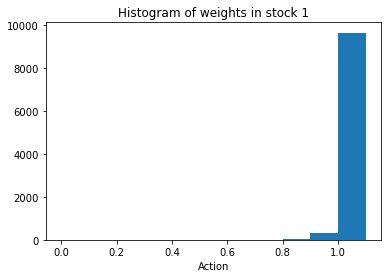

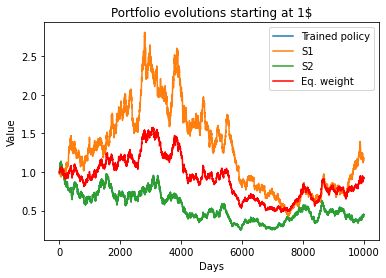

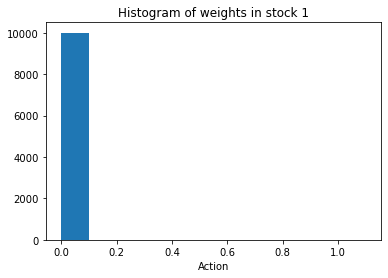

In [49]:
for j in jobs_ar3_largerbatch:
    plot_result(j['exploit_test'])

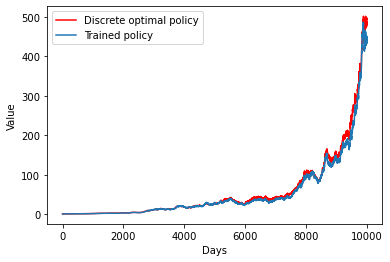

In [53]:
w_opt_ar3=exploit_optimal(true_qval_ar3, discretize(ar_test),window=1)
ret_opt_ar3= np.sum(w_opt_ar3 * ar_test.iloc[:, 1:], axis=0)
plt.plot(np.cumprod(ret_opt_ar3),'red')
plt.plot(np.cumprod(jobs_ar3_largerbatch[2]['exploit_test']['ret']))
# plt.plot(np.cumprod(ar_test.iloc[0,1:]))
# plt.plot(np.cumprod(ar_test.iloc[1,:]))
plt.legend(['Discrete optimal policy','Trained policy'])
plt.xlabel('Days')
plt.ylabel('Value')
plt.show()

## Finally, we found good parameters for window size $w=1$: 

Batch size equal to $512$, $\alpha = 0.001$. This leads to only $8$ wrong actions and those are all when both returns have same discretized return.

Performance is almost as good as for the discretized optimal policy.

# Difficulties perhaps due to length of training data

Using same seed, sample longer training data, $1'000'000$ time-steps. Apply DQN with batch size of $1'024$.

In [40]:
np.random.seed(921942)
ar_cdel=ARProcess2d([0.01,0.1],corr=0)
Nsim=1000000
Ntest=10000
ar_dat_2nd=np.exp(ar_cdel.simulate(Nsim))
ar_test_2nd=np.exp(ar_cdel.simulate(Ntest))


In [19]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.1,0.01,0.001,0.0001,0.00001,0.000001]:
        for batch_size in [1024]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat_2nd),np.array(ar_test_2nd), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_largerbatch_2nd = pool.map(multi_train, params)



 

 Parameters are : lr = 0.1, window = 1, batch size = 1024, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  81


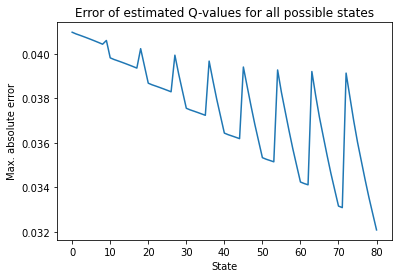


 

 Parameters are : lr = 0.01, window = 1, batch size = 1024, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


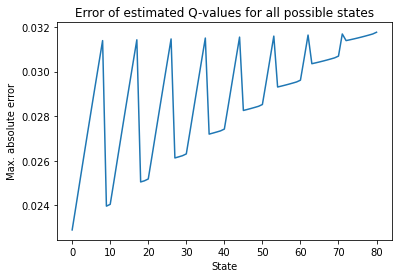


 

 Parameters are : lr = 0.001, window = 1, batch size = 1024, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


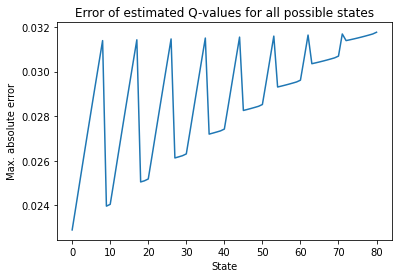


 

 Parameters are : lr = 0.0001, window = 1, batch size = 1024, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


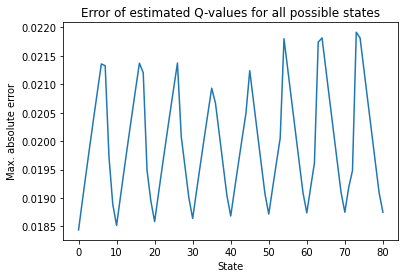


 

 Parameters are : lr = 1e-05, window = 1, batch size = 1024, nb. epochs = 100

 Wrong actions : 
[0.96, 0.96] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  4
[0.97, 0.97] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  4
[0.99, 0.99] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  7
[1.0, 1.0] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.01, 1.01] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.02, 1.02] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.03, 1.03] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.04, 1.04] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10


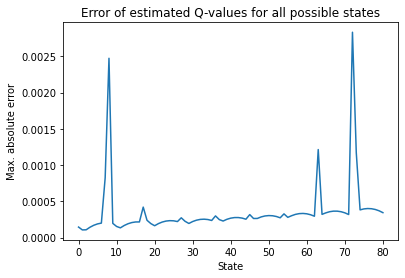


 

 Parameters are : lr = 1e-06, window = 1, batch size = 1024, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


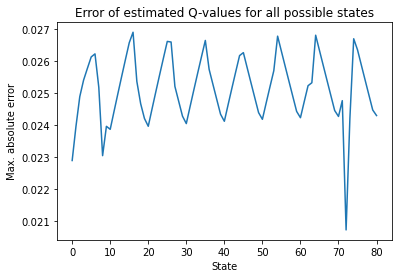

In [20]:
for j in jobs_ar3_largerbatch_2nd:
    plot_res_from_multi(j,true_qval_ar3)

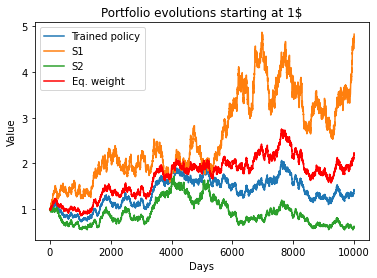

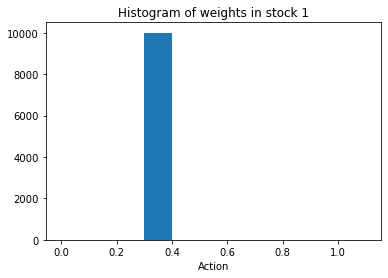

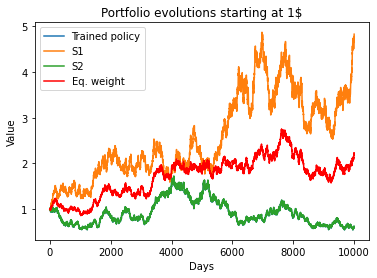

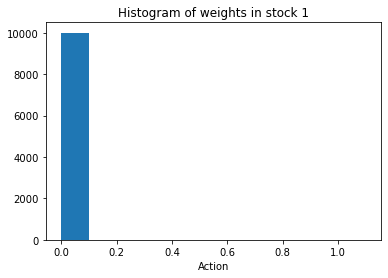

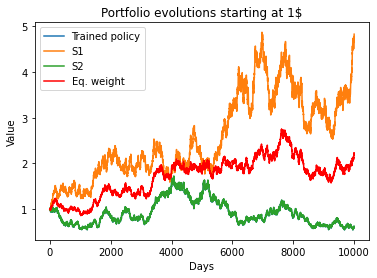

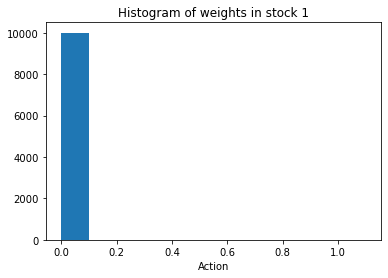

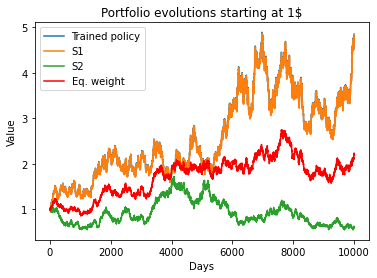

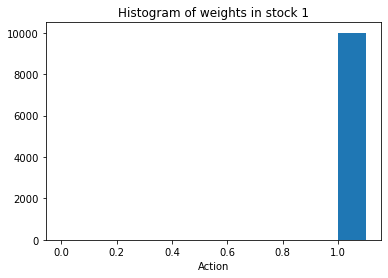

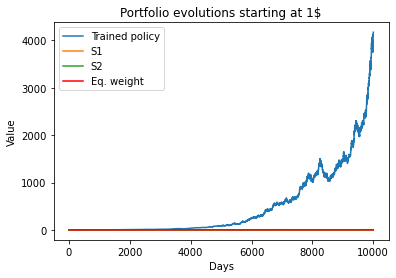

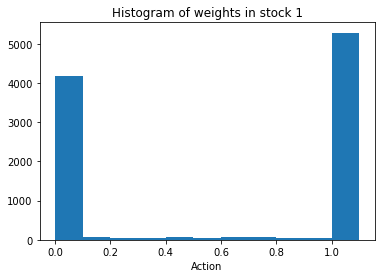

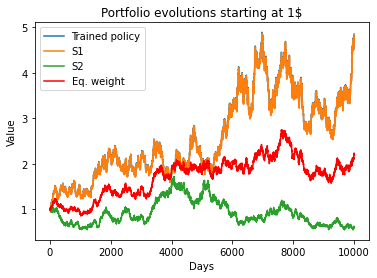

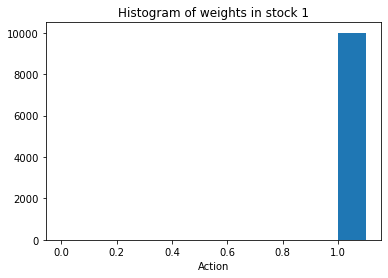

In [21]:
for j in jobs_ar3_largerbatch_2nd:
    plot_result(j['exploit_test'])

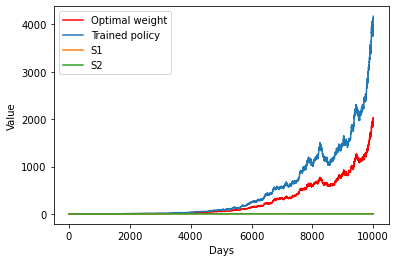

In [36]:
w_opt_ar3_2nd=exploit_optimal(true_qval_ar3, discretize(ar_test_2nd),window=1)
ret_opt_ar3_2nd = np.sum(w_opt_ar3_2nd * ar_test_2nd.iloc[:, 1:], axis=0)
plt.plot(np.cumprod(ret_opt_ar3_2nd),'red')
plt.plot(np.cumprod(jobs_ar3_largerbatch_2nd[4]['exploit_test']['ret']))
plt.plot(np.cumprod(ar_test_2nd.iloc[0,1:]))
plt.plot(np.cumprod(ar_test_2nd.iloc[1,:]))
plt.legend(['Discrete optimal policy','Trained policy', 'S1','S2'])
plt.xlabel('Days')
plt.ylabel('Value')
plt.show()

## Again only one good choice of initial step size $\alpha=1e-5$

Nevertheless, this time the learned policy outperforms the discretized optimal policy